<a href="https://colab.research.google.com/github/Adeepsn/Thesis/blob/main/EXPERIMENTAL_MODELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Download

In [1]:
from google.colab import userdata
import os

In [3]:
!unzip -q "/content/multiview-hand-pose.zip" "annotated_frames/*" -d "/content/"

In [4]:
!unzip -q "/content/multiview-hand-pose.zip" "calibrations/*" -d "/content/"

In [5]:
!rm -rf multiview-hand-pose.zip

In [6]:
!pip install -q pytorch-lightning torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 49.1 MB/s eta 0:00:00


# DATA Prep

In [7]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import json

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (12, 6)

In [8]:
import cv2
import glob, os
import numpy as np
import re
import fnmatch
import pickle
import random

def saveAnnotation(jointCamPath, positions):
    # Open a file for writing at the path specified by jointCamPath
    with open(jointCamPath, 'w') as fOut:
        # Iterate over each joint name and its corresponding position
        for i, joint in enumerate(["F4_KNU1_A", "F4_KNU1_B", "F4_KNU2_A", "F4_KNU3_A",
                                   "F3_KNU1_A", "F3_KNU1_B", "F3_KNU2_A", "F3_KNU3_A",
                                   "F1_KNU1_A", "F1_KNU1_B", "F1_KNU2_A", "F1_KNU3_A",
                                   "F2_KNU1_A", "F2_KNU1_B", "F2_KNU2_A", "F2_KNU3_A",
                                   "TH_KNU1_A", "TH_KNU1_B", "TH_KNU2_A", "TH_KNU3_A",
                                   "PALM_POSITION"]):
            # Write the joint name and its position (x, y) to the file
            fOut.write(f"{joint} {positions[i][0]} {positions[i][1]}\n")

def natural_sort(l):
    # Helper functions to split text into numbers and non-numeric parts for sorting
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    # Sort the list using the alphanum_key function
    return sorted(l, key = alphanum_key)

def recursive_glob(rootdir='.', pattern='*'):
    matches = []
    # Walk through the directory tree rooted at rootdir
    for root, dirnames, filenames in os.walk(rootdir):
        # Filter filenames matching the given pattern
        for filename in fnmatch.filter(filenames, pattern):
            # Add the full path of the matched file to the matches list
            matches.append(os.path.join(root, filename))
    return matches

def readAnnotation3D(file):
    # Open the file for reading
    with open(file, "r") as f:
        # Read the file line by line, split each line, and convert to float
        return np.array([list(map(float, line.split()[1:])) for line in f], dtype=float)

def getCameraMatrix():
    # Define the intrinsic camera matrix parameters
    Fx, Fy = 614.878, 615.479
    Cx, Cy = 313.219, 231.288
    # Return the camera matrix as a numpy array
    return np.array([[Fx, 0, Cx], [0, Fy, Cy], [0, 0, 1]])

def getDistCoeffs():
    # Return the distortion coefficients as a numpy array
    return np.array([0.092701, -0.175877, -0.0035687, -0.00302299, 0])

def main(root='/content/'):
    # Define the path to the dataset directory
    pathToDataset = os.path.join(root, "annotated_frames")
    # Get the camera matrix and distortion coefficients
    cameraMatrix = getCameraMatrix()
    distCoeffs = getDistCoeffs()

    ImgID, kpts, boxes = [], [], []
    # Iterate over 21 data directories
    for i in range(1, 22):
        # Construct the path to the data directory
        path = os.path.join(pathToDataset, f"data_{i}/")
        # Find all color frame files matching the pattern
        colorFrames = recursive_glob(path, "*_webcam_[0-9]*")
        # Sort the color frame files naturally
        colorFrames = natural_sort(colorFrames)

        calibrations = {}
        # Load calibration data for each webcam
        for cam in range(1, 5):
            rvec = pickle.load(open(f"{root}/calibrations/data_{i}/webcam_{cam}/rvec.pkl", "rb"), encoding='latin1')
            tvec = pickle.load(open(f"{root}/calibrations/data_{i}/webcam_{cam}/tvec.pkl", "rb"), encoding='latin1')
            # Store the rotation and translation vectors in the calibrations dictionary
            calibrations[cam - 1] = (rvec, tvec)

        # Iterate over each color frame
        for j, frame in enumerate(colorFrames):
            toks1 = frame.split("/")
            toks2 = toks1[-1].split("_")
            # Construct the path to the joint annotation file
            jointPath = os.path.join('/'.join(toks1[:-1]), f"{toks2[0]}_joints.txt")
            # Read the 3D joint positions from the annotation file
            points3d = readAnnotation3D(jointPath)[:21]

            # Extract the webcam ID from the filename
            webcam_id = int(toks2[-1].split(".")[0]) - 1
            rvec, tvec = calibrations[webcam_id]
            # Project the 3D points to 2D using the camera parameters
            points2d, _ = cv2.projectPoints(points3d, rvec, tvec, cameraMatrix, distCoeffs)
            # Reshape the 2D points to a list of [x, y] coordinates
            points2d_reshaped = [[i[0][0], i[0][1]] for i in points2d]
            ImgID.append(os.path.join(f"data_{i}", '_'.join(toks2)))
            kpts.append(points2d_reshaped)

            # Compute the rotation matrix from the rotation vector
            R, _ = cv2.Rodrigues(rvec)
            # Create a 4x4 transformation matrix
            T = np.eye(4)
            T[:3, :3] = R
            T[:3, 3] = tvec.flatten()

            # Transform the 3D points to the camera coordinate system
            points3d_cam = [np.dot(T, np.append(p, 1).reshape(4, 1)).flatten() for p in points3d]

            # Compute the bounding box for the 2D points
            max_x = max(p[0][0] for p in points2d)
            min_x = min(p[0][0] for p in points2d)
            max_y = max(p[0][1] for p in points2d)
            min_y = min(p[0][1] for p in points2d)

            # Compute the mean of the 3D points in the camera coordinate system
            p3d_mean = np.mean(points3d_cam, axis=0)
            # Compute an offset based on the mean depth value
            offset = p3d_mean[2] * 20 / 390
            max_x, min_x = int(max_x + offset), int(min_x - offset)
            max_y, min_y = int(max_y + offset), int(min_y - offset)

            # Add the bounding box to the boxes list
            boxes.append([min_x, min_y, max_x, max_y])

    return ImgID, kpts, boxes

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import cv2 as cv

def renderPose(img, uv, return_lbl = False):
    # Define colors for different parts of the hand
    colors = ['blue', 'orange', 'lime', 'yellow', 'cyan', 'black']
    # Define labels for different parts of the hand
    root_lbls = ['index', 'middle', 'pinky', 'ring', 'thumb', 'center']

    # Define labels for each joint in the hand
    labels = ['index3', 'index4', 'index2', 'index1',
              'middle3', 'middle4', 'middle2', 'middle1',
              'pinky3', 'pinky4', 'pinky2', 'pinky1',
              'ring3', 'ring4', 'ring2', 'ring1',
              'thumb3', 'thumb4', 'thumb2', 'thumb1',
              'center'
             ]
    # Convert uv to numpy array if it's a list
    if type(uv) == list:
        uv = np.array(uv)

    # Define connections between joints to draw the skeleton
    connections = [[0,1], [2,0], [3,2], [4,5],
                   [6,4], [7,6], [6,7], [8,9],
                   [11,10], [10,8],[12,13], [14,12],
                   [15,14],[16,17], [18,16], [19,18],
                   [20,1],[20,5], [20,9], [20,13], [20, 17]]

    iterr = -1
    # Draw lines between connected joints
    for c in connections:
        a, b = uv[c[0]].astype(int), uv[c[1]].astype(int)
        img = cv.line(np.float32(img), a, b, (255, 0, 0), 1)

    # Draw circles at each joint with different colors
    for ind, point in enumerate(uv):
        if ind % 4 == 0:
            iterr += 1
        rgb = tuple(map(lambda x: x * 255, mcolors.to_rgb(colors[iterr])))
        img = cv.circle(img, point.astype(int), 1, rgb, -1)

    # Return image and labels if return_lbl is True
    if return_lbl:
        return img, labels

    return img

def plot_image_with_bboxes(image, bbox):
    # Create a plot with one subplot
    fig, ax = plt.subplots(1, figsize=(10, 8))
    # Display the image
    ax.imshow((image).astype(np.uint8))

    # Extract bounding box coordinates
    x, y, w, h = bbox
    w, h = w - x, h - y
    # Create a rectangle patch for the bounding box
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    # Add the rectangle to the plot
    ax.add_patch(rect)
    # Show the plot
    plt.show()

def read_img(path, root = None):
    # Construct the full path if root is provided
    if root:
        path = os.path.join(root, 'annotated_frames', path)
    # Read and return the image
    return plt.imread(path)

In [10]:
imgid, kpts, boxes = main()

In [11]:
import pandas as pd

# Create a DataFrame with columns 'ImageID', 'Keypoints', and 'Boxes'
df = pd.DataFrame({
    'ImageID': imgid,   # List of image identifiers
    'Keypoints': kpts,  # List of keypoints for each image
    'Boxes': boxes      # List of bounding boxes for each image
})

# Extract the data part from the 'ImageID' column and create a new column 'data'
df['data'] = df.ImageID.apply(lambda x: x.split('/')[0])

# Display the first few rows of the DataFrame
df.head()


ImageID                                          Keypoints  \
0  data_1/0_webcam_1.jpg  [[271.75619348257266, 267.0390313453443], [319...   
1  data_1/0_webcam_2.jpg  [[378.5978629466778, 204.89257020049163], [333...   
2  data_1/0_webcam_3.jpg  [[353.7527955736016, 278.546873340722], [346.1...   
3  data_1/0_webcam_4.jpg  [[396.14184526907957, 285.43755943968586], [37...   
4  data_1/1_webcam_1.jpg  [[271.19626825153165, 266.09737706148684], [31...   

                  Boxes    data  
0  [185, 156, 434, 367]  data_1  
1  [221, 146, 466, 330]  data_1  
2  [229, 136, 439, 360]  data_1  
3  [209, 245, 492, 365]  data_1  
4  [184, 154, 433, 366]  data_1

In [12]:
df['data'].value_counts()

data
data_7     7624
data_21    7196
data_2     6600
data_12    6500
data_19    6096
data_3     6032
data_13    5804
data_15    5564
data_4     4820
data_9     4220
data_11    3800
data_10    3312
data_1     2832
data_6     2492
data_20    2028
data_14    1976
data_5     1644
data_16    1408
data_18    1280
data_17    1056
data_8      476
Name: count, dtype: int64

In [13]:
imgid[0], kpts[0]

('data_1/0_webcam_1.jpg',
 [[271.75619348257266, 267.0390313453443],
  [319.300102607668, 266.27158696962744],
  [243.75585303713237, 272.29601152858055],
  [225.11797591007274, 278.7465658022807],
  [265.4373452891503, 232.39972465843894],
  [316.8339771427481, 245.38665642960484],
  [232.90969310150945, 232.57947924562941],
  [212.94024708049926, 237.51799525957364],
  [297.0048525240911, 192.84918416252535],
  [327.171343924555, 214.56488333790236],
  [278.3750676409647, 185.6148598551388],
  [261.82725247251864, 183.66498495098367],
  [276.68237035015767, 209.25557822325825],
  [321.31816666715685, 226.9950907943483],
  [246.2280230715834, 205.84996937426152],
  [226.51046347323904, 208.66966727474716],
  [372.80650134650296, 298.98816360513854],
  [407.4477195382125, 266.1963495776931],
  [344.11115231310697, 321.5991945531807],
  [330.50117414919964, 340.6145673545511],
  [343.27159549857487, 245.28851948930983]])

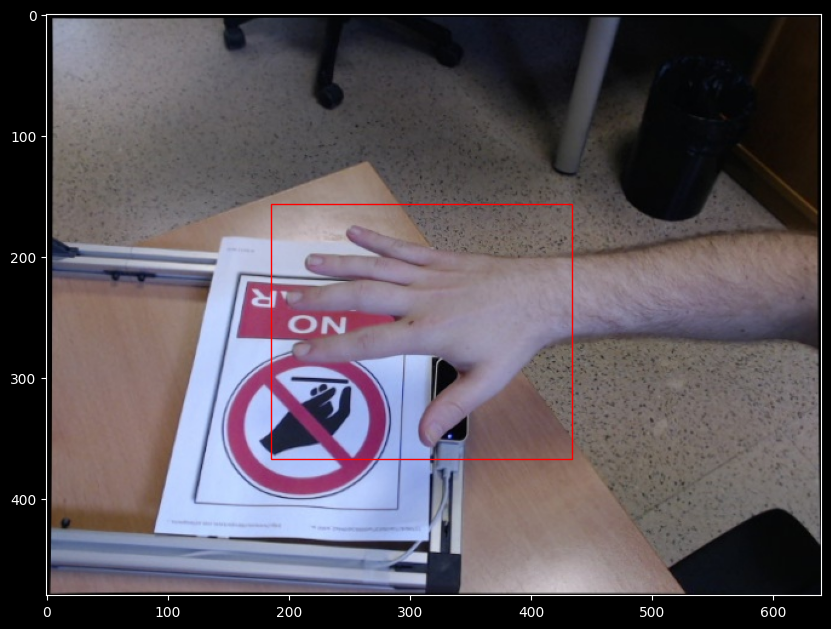

In [14]:
root = '/content/'
i = read_img(imgid[0], root)
j = renderPose(i, kpts[0])
plot_image_with_bboxes(i, boxes[0])

In [15]:
# Import the necessary libraries
import albumentations as A
import tensorflow as tf

def crop_img(img, bbox):
    """
    Crop the image based on the bounding box coordinates.

    Args:
    img (numpy.ndarray): The input image.
    bbox (list): List containing bounding box coordinates [x1, y1, x2, y2].

    Returns:
    numpy.ndarray: Cropped image.
    """
    # Extract the bounding box coordinates and convert them to integers
    x1, y1, x2, y2 = list(map(int, bbox))
    # Crop the image using the bounding box coordinates
    img = img[y1:y2, x1:x2]
    return img

def transform(img, kpt, bbox, Transform = None, img_size = 224):
    """
    Apply a series of transformations to the image and keypoints.

    Args:
    img (numpy.ndarray): The input image.
    kpt (list): List of keypoints.
    bbox (list): List containing bounding box coordinates [x1, y1, x2, y2].
    Transform (albumentations.core.composition.Compose, optional): Predefined albumentations transform. Defaults to None.
    img_size (int, optional): Desired output image size. Defaults to 224.

    Returns:
    tuple: Transformed image and keypoints.
    """
    # Define a shift limit for the ShiftScaleRotate transformation
    a = 0.1
    # Extract the bounding box coordinates and convert them to integers
    x1, y1, x2, y2 = list(map(int, bbox))

    # If no Transform is provided, create a default transformation pipeline
    if not Transform:
        Transform = A.Compose([
            A.Crop(x_min = x1, y_min = y1, x_max = x2, y_max = y2, always_apply=True, p=1.0),  # Crop the image to the bounding box
            A.Resize(img_size, img_size),  # Resize the image to the desired size
            A.Rotate(limit = 80, p = 0.5),  # Randomly rotate the image within the limit
            A.ColorJitter(p=0.5),  # Apply random changes in brightness, contrast, and saturation
            A.ShiftScaleRotate(shift_limit= a, scale_limit=0, rotate_limit=0, p=0.4),  # Apply shift and rotate transformations
#             A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Uncomment if normalization is needed
        ],
        keypoint_params = A.KeypointParams(format="xy", remove_invisible = False)  # Parameters for keypoint transformations
        )

    # Apply the transformations to the image and keypoints
    transformed = Transform(
          image=img,
          keypoints=kpt,
    )

    # Extract the transformed image and keypoints
    img, kpts = transformed['image'], transformed['keypoints']
    # Convert the keypoints to a numpy array
    kpts = np.array(kpts)
    return img, kpts

In [16]:
# Import necessary libraries
import torch
import torch.utils.data as data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import os
import cv2 as cv

class IdxGenerator:
    """
    A class to generate train and test indices.
    """
    def __init__(self, n, test_size, seed):
        """
        Initialize the index generator with the number of samples, test size, and random seed.

        Args:
        n (int): Total number of samples.
        test_size (float): Proportion of data to be used for testing.
        seed (int): Random seed for reproducibility.
        """
        idx = np.arange(n).tolist()  # Create a list of indices from 0 to n-1
        np.random.seed(seed)  # Set the random seed
        # Randomly select indices for training data
        self.trainIdx = np.random.choice(idx, size = int(n * (1 - test_size)), replace = False).tolist()
        # The remaining indices are used for testing data
        self.testIdx = list(set(idx).difference(set(self.trainIdx)))
        print(f'Length of training data : {len(self.trainIdx)}')
        print(f'Length of testing data : {len(self.testIdx)}')

class HandPose(data.Dataset):
    """
    A PyTorch Dataset class for hand pose data.
    """
    def __init__(self, df, transform = None, imgSize = 224, subset = 'train', root = None, testSize = 0.2, seed = 0):
        """
        Initialize the dataset with DataFrame, transformations, image size, subset, and other parameters.

        Args:
        df (pd.DataFrame): DataFrame containing the dataset.
        transform (callable, optional): A function/transform to apply to the image and keypoints.
        imgSize (int, optional): The size to which images should be resized. Defaults to 224.
        subset (str, optional): Whether to use 'train' or 'test' subset. Defaults to 'train'.
        root (str, optional): Root directory where images are stored.
        testSize (float, optional): Proportion of data to be used for testing. Defaults to 0.2.
        seed (int, optional): Random seed for reproducibility. Defaults to 0.
        """
        self.transform = transform  # Transformation function or pipeline
        self.imgSize = imgSize  # Desired image size
        self.idxGen = IdxGenerator(df.shape[0], testSize, seed)  # Index generator instance
        self.root = root  # Root directory for image paths

        # Select the subset (training or testing) based on provided indices
        if subset == 'train':
            data = df.iloc[self.idxGen.trainIdx, :]
        else:
            data = df.iloc[self.idxGen.testIdx, :]

        self.data = data.reset_index(drop = True)  # Reset index for the subset data
        self.length = self.data.shape[0]  # Number of samples in the dataset

    def __getitem__(self, ind):
        """
        Get a sample from the dataset.

        Args:
        ind (int): Index of the sample to retrieve.

        Returns:
        tuple: (image, keypoints) where image is a tensor and keypoints are a tensor.
        """
        sdf = self.data.iloc[ind, :]  # Retrieve the sample data at index ind
        imgid, kpts, box = sdf.ImageID, sdf.Keypoints, sdf.Boxes  # Extract image ID, keypoints, and bounding box
        img = plt.imread(os.path.join(self.root, imgid))  # Load the image from the file
        kpts = np.array(kpts).astype(int)  # Convert keypoints to numpy array and ensure they are integers

        # Check if the image is grayscale and convert to RGB if necessary
        if len(img.shape) != 3:
            img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)

        self.height, self.width, self.ch = img.shape  # Get the dimensions of the image

        # Ensure the bounding box coordinates are within the image bounds
        if box[0] > box[2] or box[1] > box[3]:
            print(box, 'before correction', imgid)
        box = [max(0, box[0]), max(0, box[1]), min(self.width, box[2]), min(self.height, box[3])]
        if box[0] > box[2] or box[1] > box[3]:
            print(box, 'after correction', imgid)

        # Apply transformations if provided, otherwise use default transformations
        if self.transform:
            img, kpts = self.transform(img, kpts, box, img_size = self.imgSize)
        else:
            x1, y1, x2, y2 = list(map(int, box))
            transformer = A.Compose([
                A.Crop(x_min = x1, y_min = y1, x_max = x2, y_max = y2, always_apply=True, p=1.0),
                A.Resize(self.imgSize, self.imgSize)
            ],
            keypoint_params = A.KeypointParams(format="xy", remove_invisible = False))
            img, kpts = transform(img, kpts, transformer)

        img = img / 255  # Normalize the image to the range [0, 1]
        img = torch.from_numpy(img.astype(np.float32)).permute(-1, 0, 1)  # Convert image to tensor and rearrange dimensions (C, H, W)
        kpts = (kpts / self.imgSize).flatten().astype(np.float32)  # Normalize and flatten keypoints
        kpts = torch.from_numpy(kpts)  # Convert keypoints to tensor
        return img, kpts

    def orig_size(self, ind):
        """
        Get the original size of the image at a given index.

        Args:
        ind (int): Index of the sample.

        Returns:
        tuple: (height, width, channels) of the image.
        """
        sdf = self.data.iloc[ind, :]  # Retrieve the sample data at index ind
        imgid = sdf.ImageID  # Extract image ID
        img = plt.imread(os.path.join(self.root, imgid))  # Load the image from the file
        return img.shape  # Return the shape of the image

    def __len__(self):
        """
        Get the number of samples in the dataset.

        Returns:
        int: Number of samples in the dataset.
        """
        return self.length

In [17]:
def get_rows(n, c):
    """
    Calculate the number of rows required to arrange `n` images in a grid with `c` columns.

    Args:
    n (int): Total number of images.
    c (int): Number of columns in the grid.

    Returns:
    int: Number of rows needed.
    """
    if n % c == 0:
        return n // c  # If `n` is perfectly divisible by `c`, return the integer division result.
    return (n // c) + 1  # Otherwise, add 1 to cover the remaining images.

In [18]:
def plot_images(data, n = 10, c = 5):
    """
    Plot a grid of images with their keypoints.

    Args:
    data (DataLoader): DataLoader instance providing images and keypoints.
    n (int, optional): Number of images to plot. Defaults to 10.
    c (int, optional): Number of columns in the grid. Defaults to 5.
    """
    r = get_rows(n, c)  # Calculate the number of rows needed for the grid.
    plt.figure(figsize = (c*3, r*4))  # Set the figure size based on the number of columns and rows.
    plt.tight_layout()  # Adjust subplot parameters to give some padding.

    img, kpts = next(iter(data))  # Retrieve a batch of images and keypoints from the DataLoader.
    for ind in range(n):
        image = img[ind].detach().permute(1, -1, 0).numpy().copy()  # Convert tensor to numpy array and rearrange dimensions.
        kpt = (kpts[ind].detach().numpy().reshape(-1, 2) * image.shape[0]).astype(int)  # Reshape and scale keypoints to match image size.
        plt.subplot(r, c, ind + 1)  # Create a subplot for the current image.
        nimage = renderPose(image, kpt)  # Render the image with keypoints.
        plt.imshow(nimage)  # Display the rendered image.
        plt.axis(False)  # Hide the axes.


In [19]:
name = 'data_20/202_webcam_4.jpg'
df[df.ImageID == name]

ImageID  \
74347  data_20/202_webcam_4.jpg   

                                               Keypoints  \
74347  [[378.4189569377179, 309.43244297005464], [365...   

                      Boxes     data  
74347  [297, 328, 415, 316]  data_20

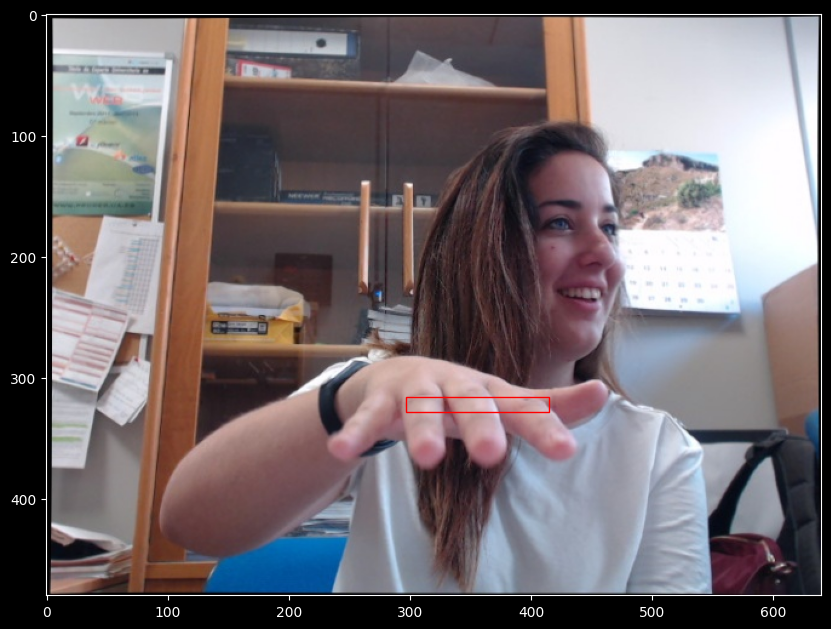

In [20]:
b = [297, 316, 415, 328]
i = read_img(name, root)
plot_image_with_bboxes(i, b)

In [21]:
ndf = df.copy()
ndf[['xmin', 'ymin', 'xmax', 'ymax']] = ndf.Boxes.apply(lambda x: pd.Series(x))

<Figure size 600x600 with 0 Axes>

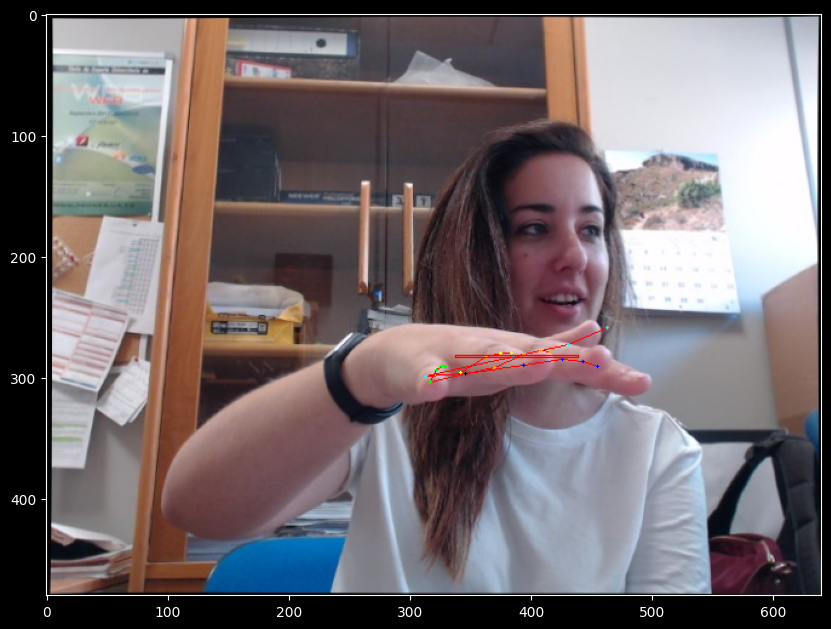

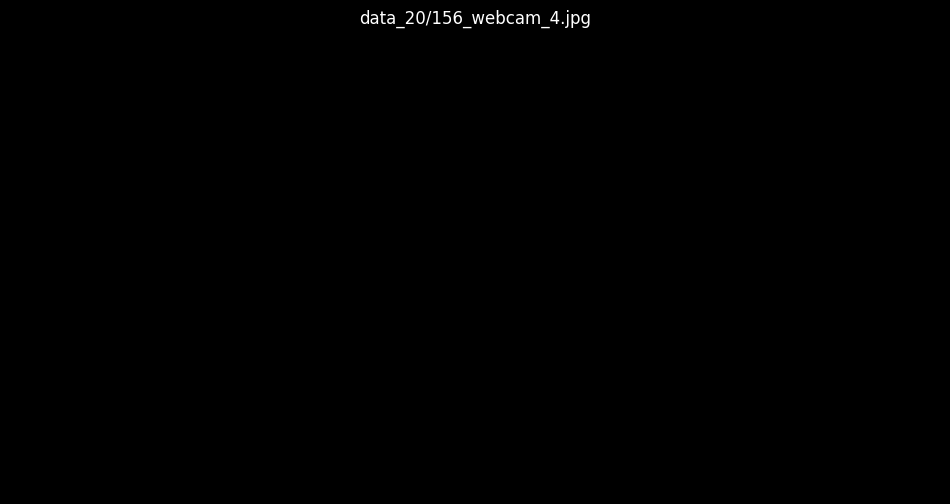

<Figure size 600x600 with 0 Axes>

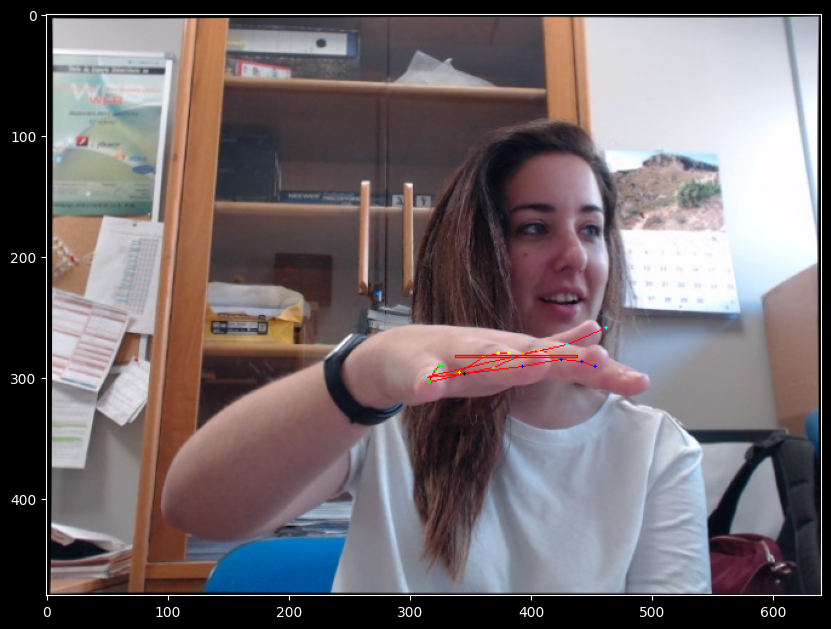

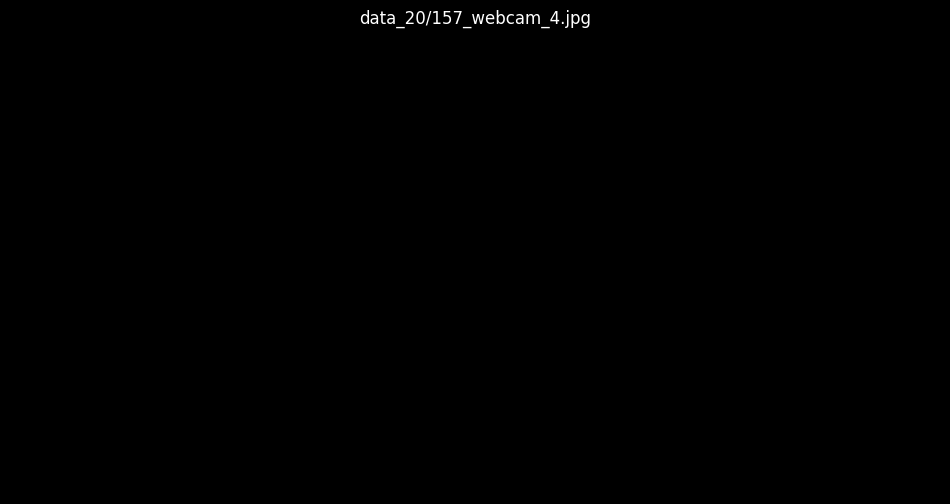

<Figure size 600x600 with 0 Axes>

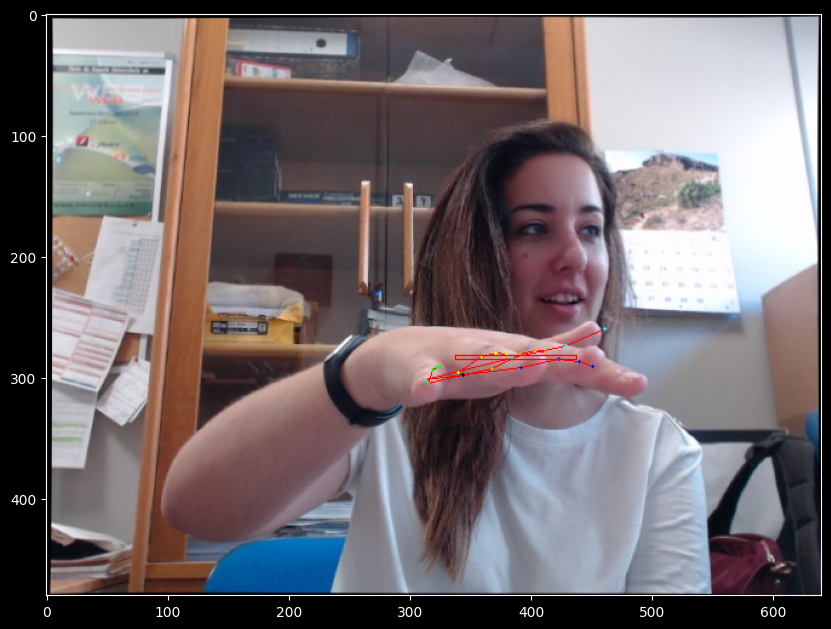

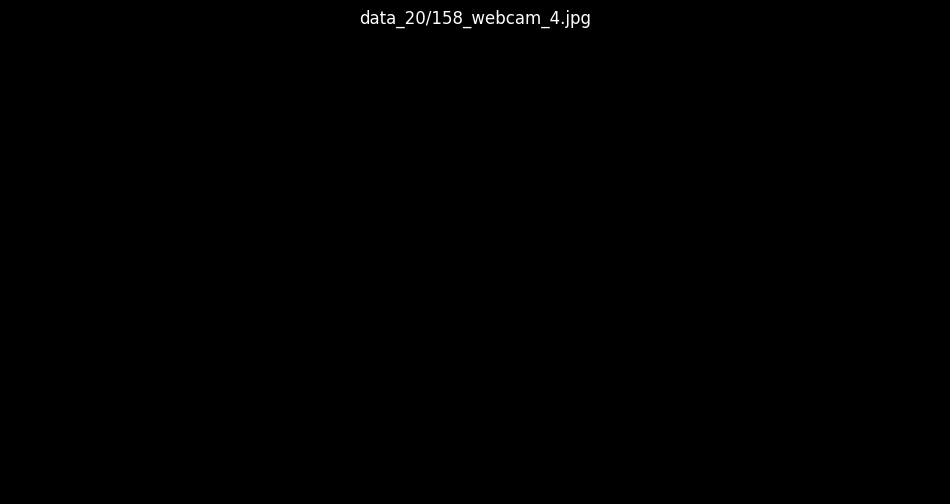

<Figure size 600x600 with 0 Axes>

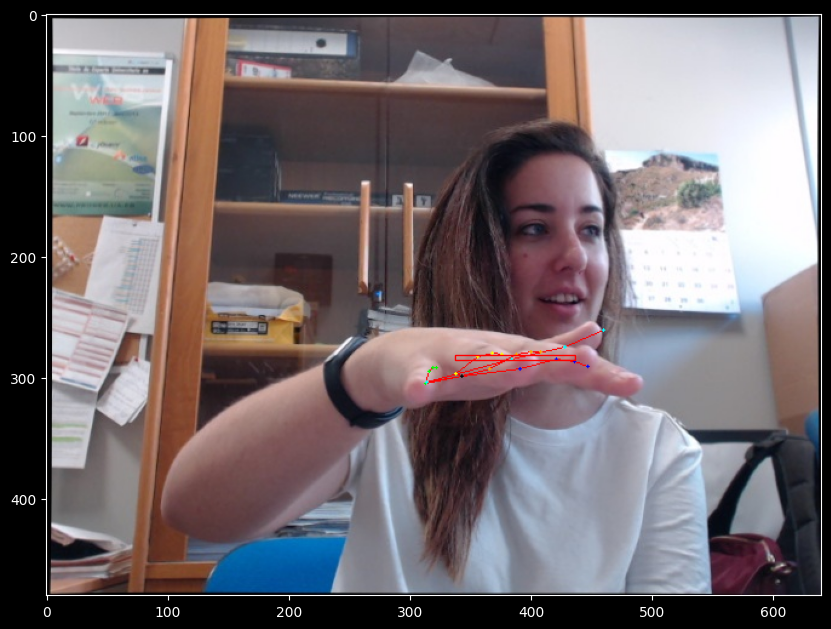

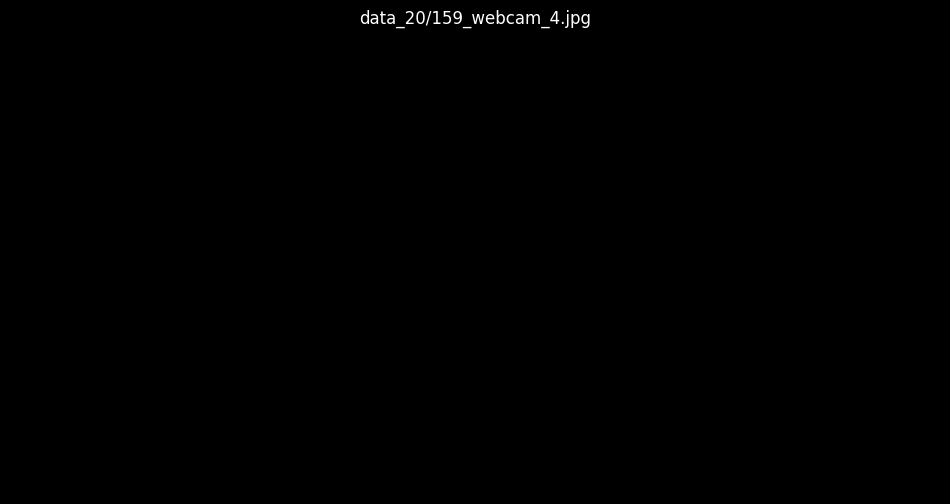

<Figure size 600x600 with 0 Axes>

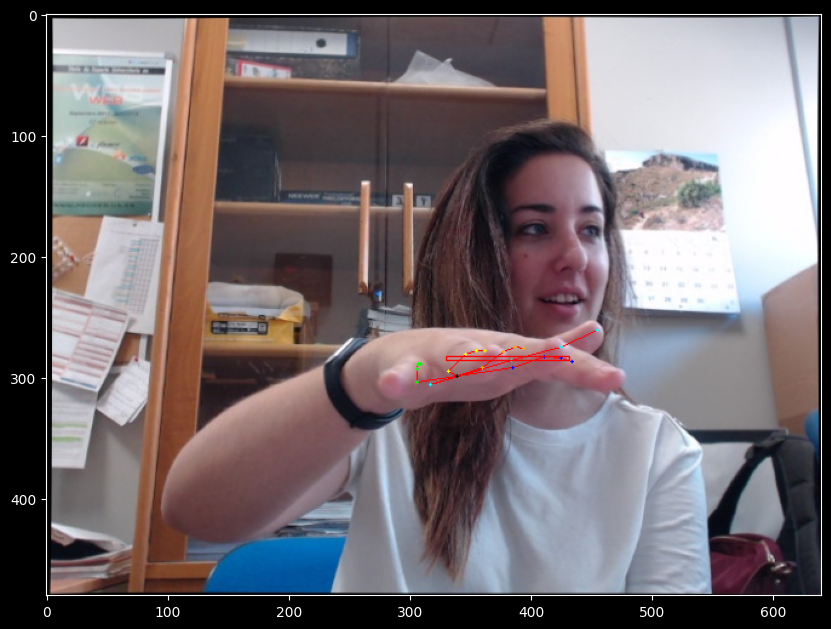

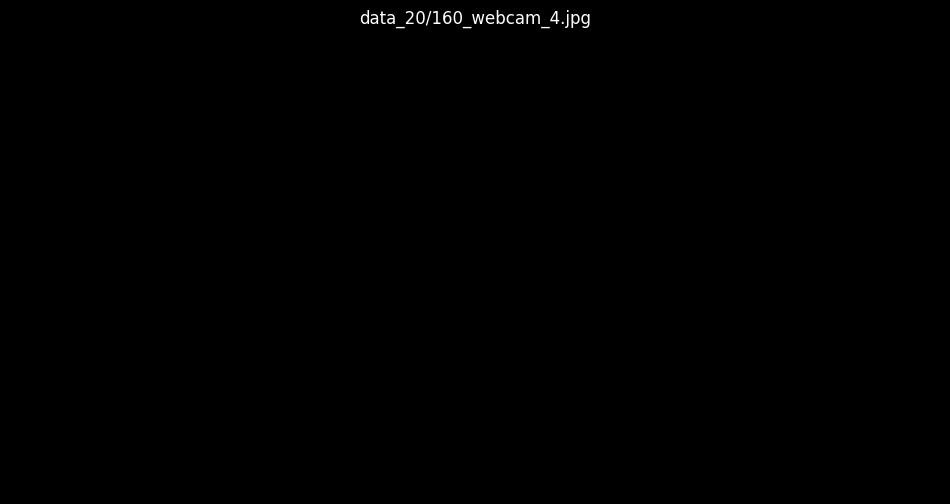

<Figure size 600x600 with 0 Axes>

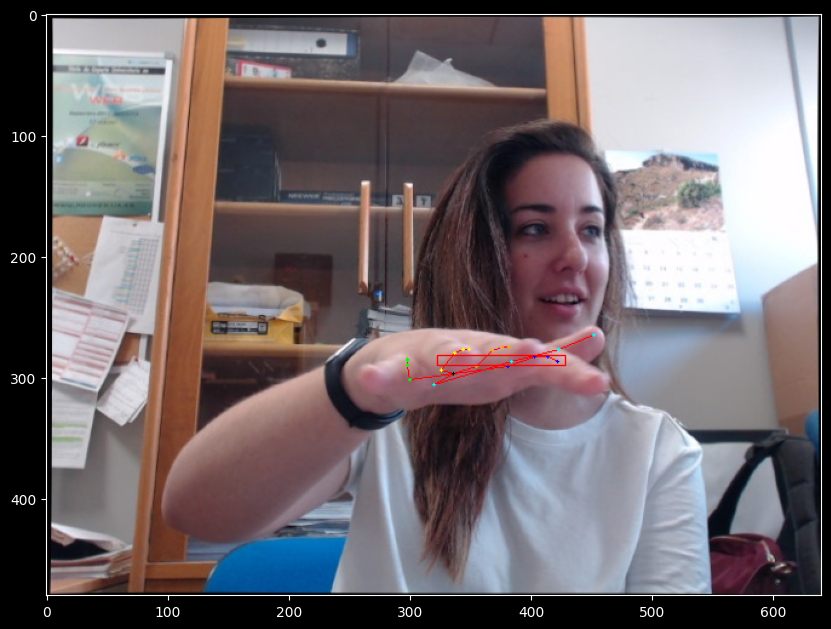

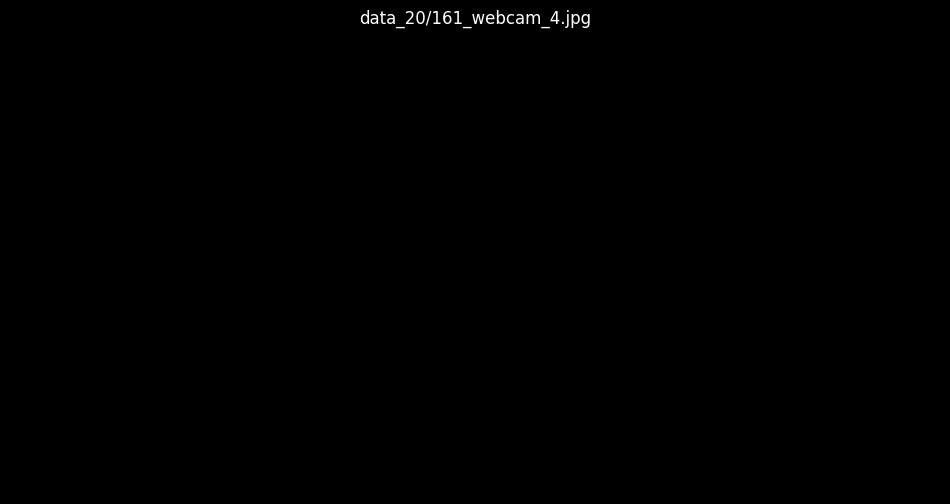

<Figure size 600x600 with 0 Axes>

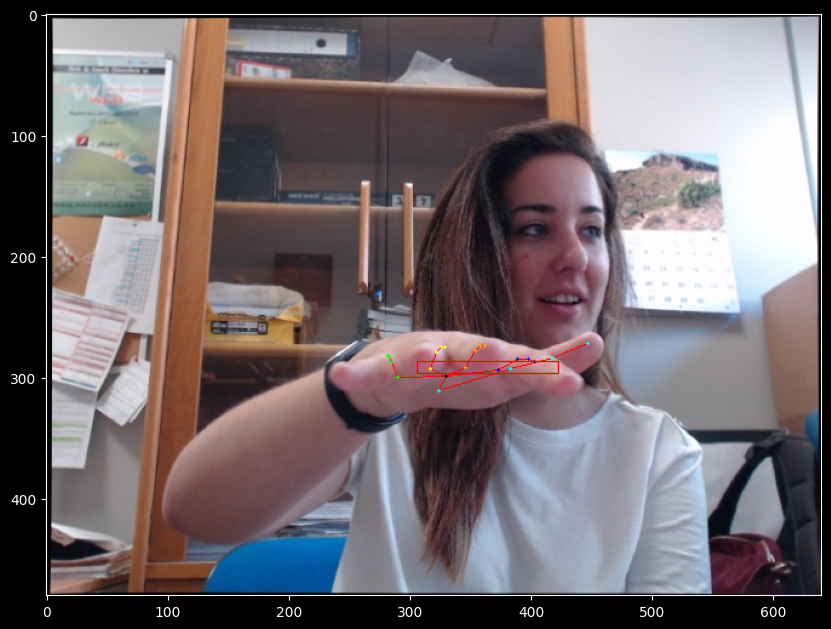

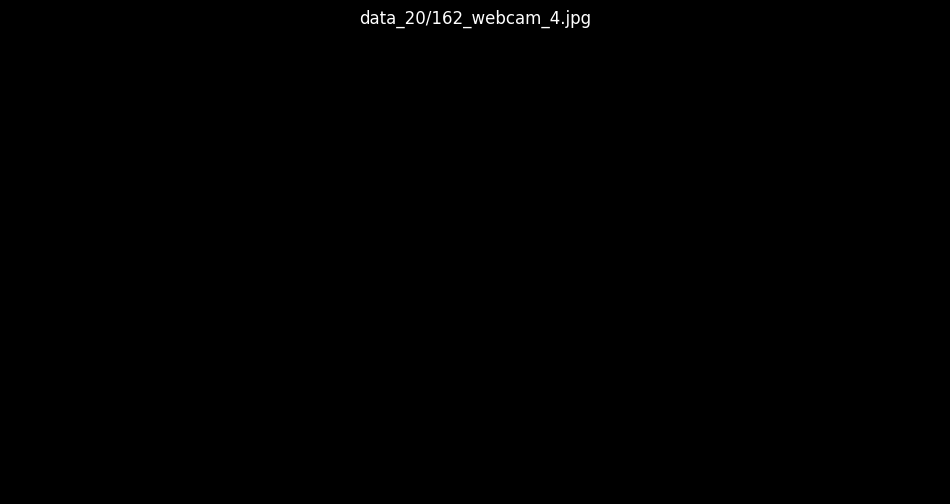

<Figure size 600x600 with 0 Axes>

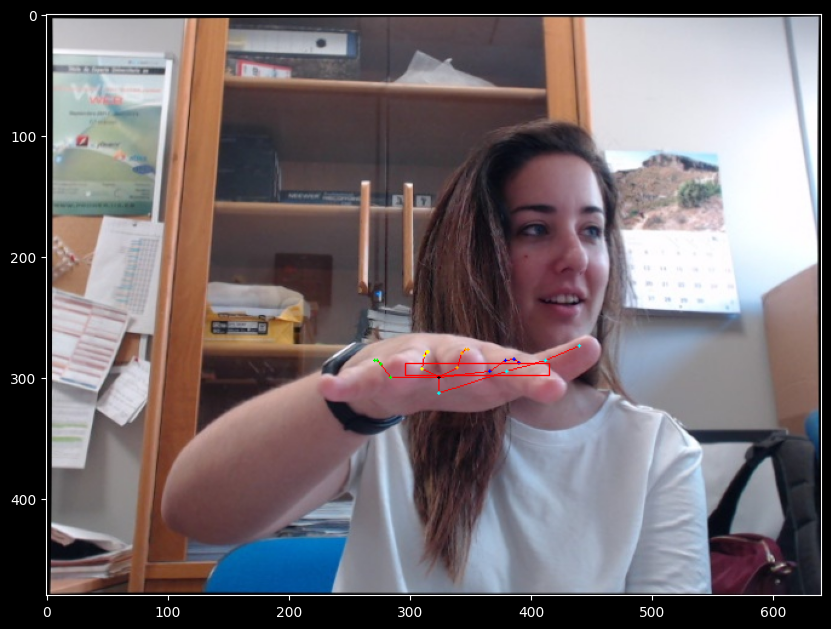

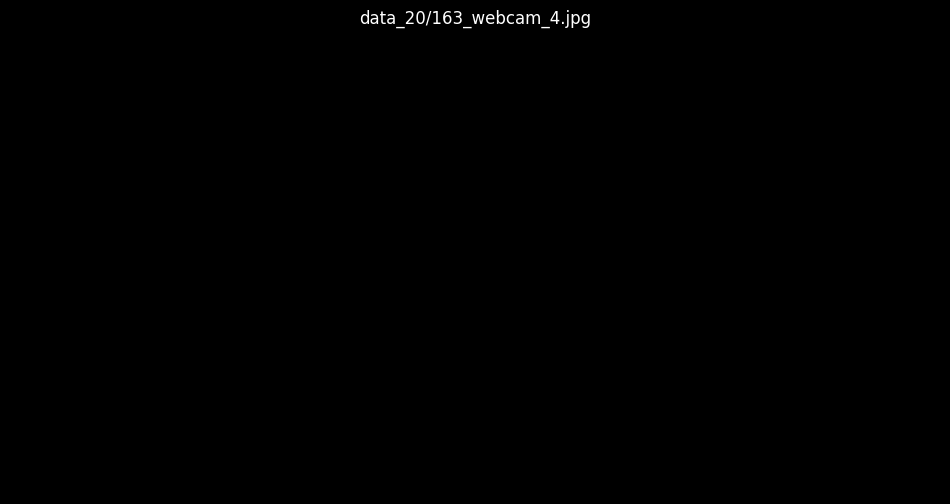

<Figure size 600x600 with 0 Axes>

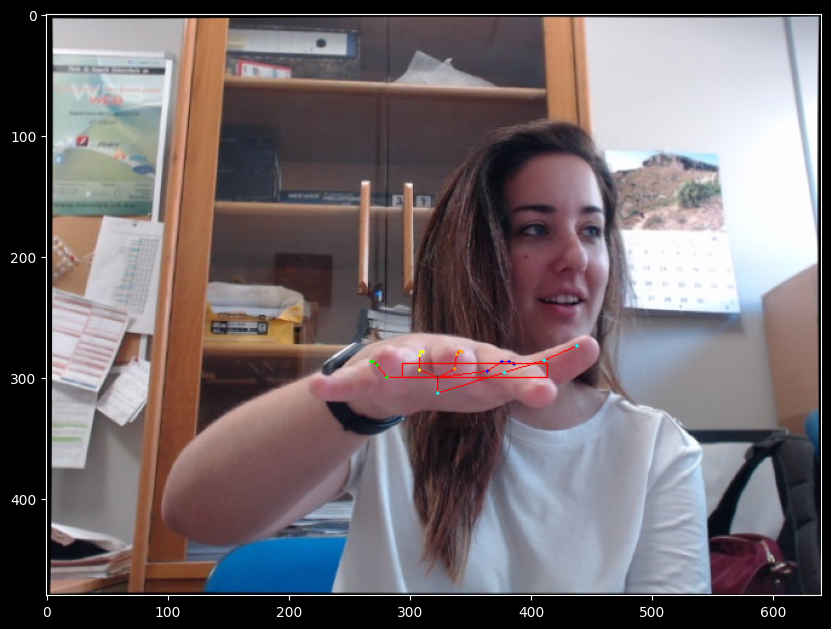

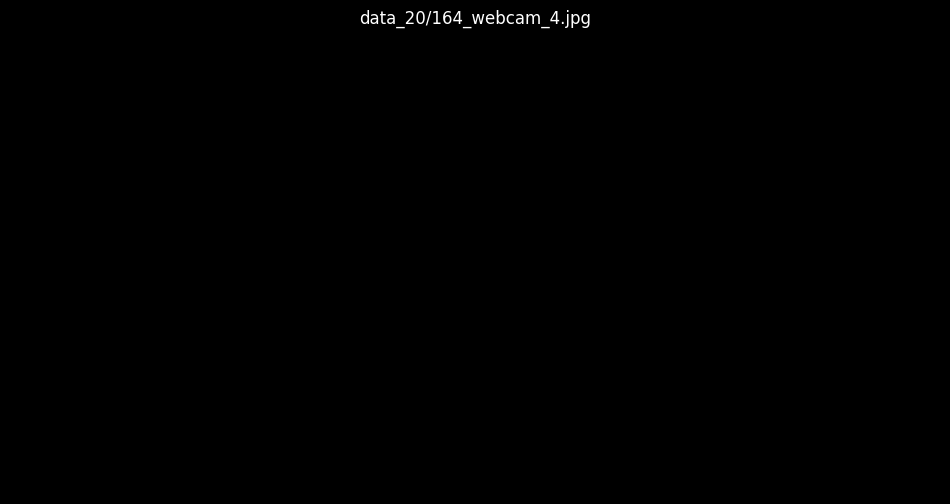

<Figure size 600x600 with 0 Axes>

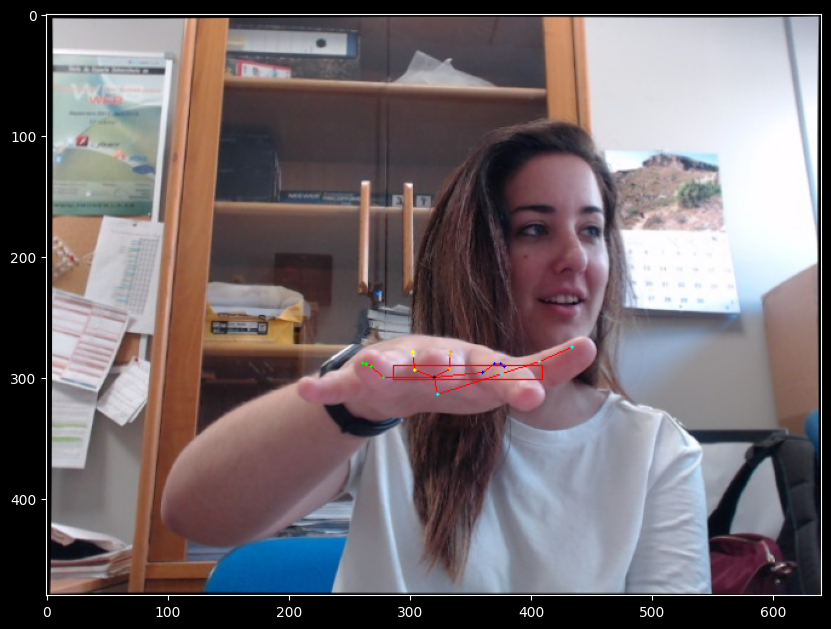

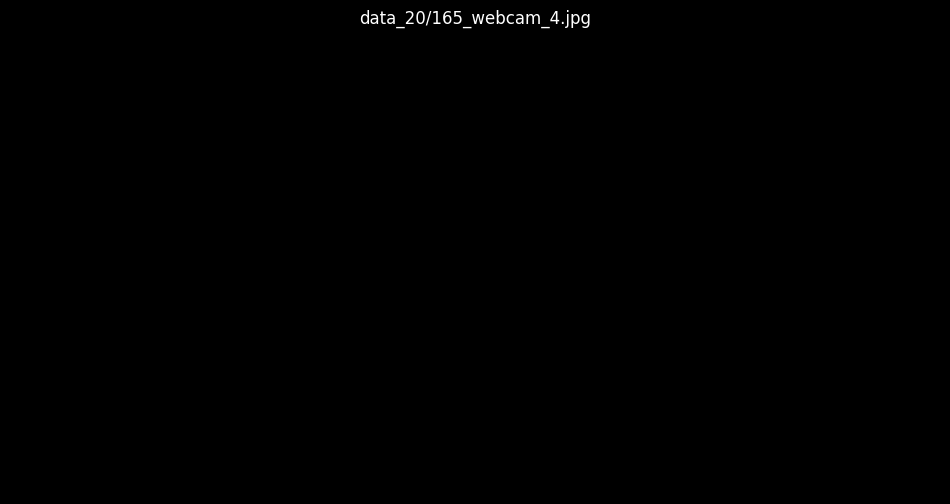

In [22]:
for ind, rdf in ndf[(ndf.ymin > ndf.ymax).values][:10].iterrows():
    plt.figure(figsize = (6,6))
    plot_image_with_bboxes(renderPose(read_img(rdf.ImageID, root), rdf.Keypoints), rdf.Boxes)
    plt.axis(False)
    plt.title(rdf.ImageID)

In [23]:
xidx = ndf[(ndf.xmin > ndf.xmax).values].index.tolist()
yidx = ndf[(ndf.ymin > ndf.ymax).values].index.tolist()
drop_idx = xidx + yidx
print(f'Number of drop index : {len(drop_idx)}')

Number of drop index : 28


In [24]:
df = df.drop(drop_idx).reset_index(drop = True)
print(df.shape[0])
print(ndf.shape[0])

82732
82760


In [25]:
kdf = df.copy()
kdf[['xmin', 'ymin', 'xmax', 'ymax']] = kdf.Boxes.apply(lambda x: pd.Series(x))
kdf.head()

ImageID                                          Keypoints  \
0  data_1/0_webcam_1.jpg  [[271.75619348257266, 267.0390313453443], [319...   
1  data_1/0_webcam_2.jpg  [[378.5978629466778, 204.89257020049163], [333...   
2  data_1/0_webcam_3.jpg  [[353.7527955736016, 278.546873340722], [346.1...   
3  data_1/0_webcam_4.jpg  [[396.14184526907957, 285.43755943968586], [37...   
4  data_1/1_webcam_1.jpg  [[271.19626825153165, 266.09737706148684], [31...   

                  Boxes    data  xmin  ymin  xmax  ymax  
0  [185, 156, 434, 367]  data_1   185   156   434   367  
1  [221, 146, 466, 330]  data_1   221   146   466   330  
2  [229, 136, 439, 360]  data_1   229   136   439   360  
3  [209, 245, 492, 365]  data_1   209   245   492   365  
4  [184, 154, 433, 366]  data_1   184   154   433   366

In [26]:
# Initialize the index variable for tracking the current row
ind = 0

def error_kpts(x):
    global ind
    # Unpack the list of keypoints into separate x and y coordinates
    x, y = list(zip(*x))
    # Convert x and y coordinates to numpy arrays for efficient processing
    x, y = np.array(x), np.array(y)
    error = False

    # Check if any x-coordinate is outside the bounding box's xmin and xmax
    if (x < kdf.iloc[ind].xmin).sum() > 0 or (x > kdf.iloc[ind].xmax).sum() > 0:
        error = True

    # Check if any y-coordinate is outside the bounding box's ymin and ymax
    if (y < kdf.iloc[ind].ymin).sum() > 0 or (y > kdf.iloc[ind].ymax).sum() > 0:
        error = True

    # Increment the index to move to the next row for the next call
    ind += 1
    # Return whether an error was detected in the keypoints
    return error

# Apply the error_kpts function to each row of the Keypoints column in kdf
# The function will check if the keypoints are within the bounding box defined in each row
ekpts = kdf.Keypoints.apply(lambda x: error_kpts(x))

# Get the indices of rows where the error_kpts function returned True
ind = kdf[ekpts.values].index

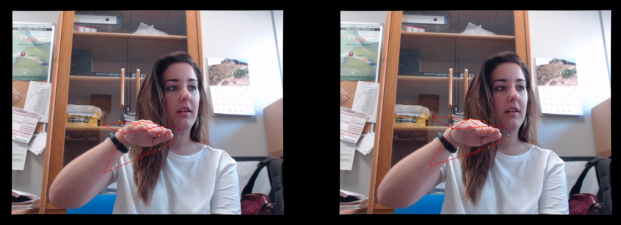

In [27]:
root = '/content/'
iterr = 0
def eplot(ind):
    global iterr
    # Create a subplot in a 1-row, 3-column grid; cycle through columns based on `iterr`
    plt.subplot(1, 3, max(1, (iterr + 1) % 3))

    # Retrieve the current row of the DataFrame using the index provided
    q = kdf.iloc[ind[iterr]]

    # Extract the bounding box and keypoints from the current row
    b = q.Boxes

    # Read the image from the path specified in the DataFrame, render it with keypoints,
    # and convert the result to an 8-bit unsigned integer format for display
    plt.imshow(renderPose(read_img(q.ImageID, root), q.Keypoints).astype(np.uint8))

    # Hide the axis for a cleaner display of the image
    plt.axis(False)

    # Increment the iterator to move to the next subplot position in the next call
    iterr += 1

# Call `eplot` function three times to plot three images with keypoints in a single row of subplots
eplot(ind)
eplot(ind)
eplot(ind)


In [28]:
df = df.drop(ind.tolist()).reset_index(drop = True)
df.shape

(82253, 4)

In [29]:
root = '/content/'
iroot = os.path.join(root, 'annotated_frames')
HP = HandPose(df,transform, root = iroot, testSize = .1, subset = 'train')
Data = data.DataLoader(HP, shuffle = True, batch_size = 128)
HP_val = HandPose(df,transform, root = iroot, testSize = .1, subset = 'validation')
Data_val = data.DataLoader(HP, shuffle = True, batch_size = 128)

Length of training data : 74027
Length of testing data : 8226
Length of training data : 74027
Length of testing data : 8226


# UTILS

In [30]:
def compute_pck(preds, kpts, threshold=0.2):
    """
    Compute the Percentage of Correct Keypoints (PCK).

    Args:
        preds (torch.Tensor): Predicted keypoints of shape (batch_size, num_keypoints * 2)
        kpts (torch.Tensor): Ground truth keypoints of shape (batch_size, num_keypoints * 2)
        threshold (float): The normalized distance threshold (e.g., 0.2 means 20% of the image size)

    Returns:
        pck (float): The percentage of keypoints that are within the threshold distance
    """
    # Reshape to (batch_size, num_keypoints, 2)
    preds = preds.view(preds.size(0), -1, 2)
    kpts = kpts.view(kpts.size(0), -1, 2)

    # Compute the Euclidean distance between predicted and true keypoints
    dists = torch.sqrt(torch.sum((preds - kpts) ** 2, dim=-1))  # Shape: (batch_size, num_keypoints)

    # Compute the threshold distance based on the image size
    bbox_size = torch.max(kpts, dim=1)[0] - torch.min(kpts, dim=1)[0]
    threshold_dist = threshold * torch.max(bbox_size, dim=-1)[0]

    # Compute the percentage of keypoints within the threshold
    correct_keypoints = (dists < threshold_dist.unsqueeze(1)).float()
    pck = correct_keypoints.mean().item()

    return pck

def compute_mje(preds, kpts):
    """
    Compute the Mean Joint Error (MJE).

    Args:
        preds (torch.Tensor): Predicted keypoints of shape (batch_size, num_keypoints * 2)
        kpts (torch.Tensor): Ground truth keypoints of shape (batch_size, num_keypoints * 2)

    Returns:
        mje (float): The mean Euclidean distance between the predicted keypoints and ground truth keypoints
    """
    # Reshape to (batch_size, num_keypoints, 2)
    preds = preds.view(preds.size(0), -1, 2)
    kpts = kpts.view(kpts.size(0), -1, 2)

    # Compute the Euclidean distance between predicted and true keypoints
    errors = torch.sqrt(torch.sum((preds - kpts) ** 2, dim=-1))  # Shape: (batch_size, num_keypoints)

    # Mean joint error
    mje = errors.mean().item()

    return mje

In [31]:
import pytorch_lightning as pl

class MetricsLogger(pl.Callback):
    def __init__(self):
        super().__init__()
        self.metrics = {
            'train_loss': [], 'train_mse': [], 'train_mae': [], 'train_pck': [], 'train_mje': [],
            'val_loss': [], 'val_mse': [], 'val_mae': [], 'val_pck': [], 'val_mje': []
        }
        self.epochs = 0

    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        print(f"Epoch {epoch} - Train Metrics: "
              f"Loss: {metrics['train_loss'].item()}, "
              f"MSE: {metrics['train_mse'].item()}, "
              f"MAE: {metrics['train_mae'].item()}, ",
              f"PCK: {metrics['train_pck'].item()}, "
              f"MJE: {metrics['train_mje'].item()} \n\n")
        self.epochs += 1

    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        print(f"Epoch {epoch} - Validation Metrics: "
              f"Loss: {metrics['val_loss'].item()}, "
              f"MSE: {metrics['val_mse'].item()}, "
              f"MAE: {metrics['val_mae'].item()}, "
              f"PCK: {metrics['val_pck'].item()}, "
              f"MJE: {metrics['val_mje'].item()} ")


# Create an instance of MetricsLogger
metrics_logger = MetricsLogger()

In [32]:
def predict_(model, img, bbox, IMG_SIZE = 224):
    x1,y1,x2,y2 = list(map(int, bbox))
    transformer = A.Compose([
        A.Crop(x_min = x1, y_min = y1, x_max = x2, y_max = y2, always_apply=True, p=1.0),
        A.Resize(IMG_SIZE, IMG_SIZE)])
    img = (transformer(image = img)['image'] / 255).astype(np.float32)
    img = torch.from_numpy(img).permute(-1, 0, 1)
    img = torch.unsqueeze(img, dim = 0)
    model.eval()
    with torch.no_grad():
        preds = torch.squeeze(model(img))
    return torch.squeeze(img.detach()).permute(1,-1,0).numpy().copy(), (preds.reshape(-1, 2).numpy() * IMG_SIZE).astype(np.uint32)

In [33]:
tidx = IdxGenerator(df.shape[0], .1, 0).testIdx
tdf = df.iloc[tidx]
tdf.head()

Length of training data : 74027
Length of testing data : 8226


ImageID  \
10        data_1/2_webcam_3.jpg   
32779    data_9/64_webcam_4.jpg   
65547  data_17/110_webcam_4.jpg   
13        data_1/3_webcam_2.jpg   
32787    data_9/66_webcam_4.jpg   

                                               Keypoints  \
10     [[352.8275527518978, 278.9541831366298], [344....   
32779  [[425.7878086116697, 184.27241379250026], [378...   
65547  [[383.3428009806578, 276.22235275501885], [361...   
13     [[377.44452738851135, 200.04488858665835], [33...   
32787  [[422.91153484920545, 183.28985168544386], [37...   

                      Boxes     data  
10     [230, 136, 438, 361]   data_1  
32779   [254, 79, 497, 332]   data_9  
65547  [255, 231, 409, 369]  data_17  
13     [218, 137, 466, 324]   data_1  
32787   [258, 83, 496, 320]   data_9

In [34]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

def RMSE(true, preds):
    return np.sqrt(np.mean(np.square(true - preds)))

def MAE(true, preds):
    return mean_absolute_error(true, preds)

def MSE(true, preds):
    return mean_squared_error(true, preds)

def pred_batches(mod, loader, num_batches=1):
    tkpts = []
    pkpts = []
    iterr = 0
    for batch in loader:
        if iterr >= num_batches:
            break
        img, kpts = batch
        mod.eval()
        with torch.no_grad():
            kpts = kpts.detach().cpu().numpy()
            preds = mod(img).detach().cpu().numpy()
            for i in tqdm(range(preds.shape[0])):
                tkpts.append(kpts[i])
                pkpts.append(preds[i])
        iterr += 1

    true = np.array(tkpts)
    preds = np.array(pkpts)
    print(true.shape, preds.shape)

    # Overall metrics
    print(f'Total RMSE : {RMSE(true, preds)}')
    print(f'Total MAE : {MAE(true, preds)}')
    print(f'Total MSE : {MSE(true, preds)}')
    print(f'Total PCK : {compute_pck(torch.from_numpy(preds), torch.from_numpy(true))}')
    print(f'Total MJE : {compute_mje(torch.from_numpy(preds), torch.from_numpy(true))}')

    root_lbls = ['index', 'middle', 'pinky', 'ring', 'thumb', 'center']
    st = 0
    for i in range(6):
        curr_finger = root_lbls[i]
        ed = st + 4
        strue = true[:, st:ed]
        spreds = preds[:, st:ed]
        print(f'{curr_finger} finger RMSE : {RMSE(strue, spreds)}')
        print(f'{curr_finger} finger MAE : {MAE(strue, spreds)}')
        print(f'{curr_finger} finger MSE : {MSE(strue, spreds)}')
        print(f'{curr_finger} finger PCK : {compute_pck(torch.from_numpy(spreds), torch.from_numpy(strue))}')
        print(f'{curr_finger} finger MJE : {compute_mje(torch.from_numpy(spreds), torch.from_numpy(strue))}')
        st = ed

# Modelling

In [35]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
import torchvision.models as models
import pytorch_lightning as pl
from torch.nn import functional as F
import torch.nn as nn
import torchmetrics

## MobNetV3-small

In [36]:


class MobNetV3_Small(pl.LightningModule):
    def __init__(self, k = 21*2, test_size = 0.2, verbose = False):
        super(MobNetV3_Small, self).__init__()
        torch.cuda.empty_cache()
        self.test_size = test_size
        self.verbose = verbose
        self.criterion = nn.MSELoss().cuda()
        self.model = models.mobilenet_v3_small(pretrained=True, progress = True)
        # num_features = self.model.classifier[1].in_features
        num_features = self.model.classifier[3].in_features
        if verbose:
            print(f'Number of features in the last layer : {num_features}')
            print(f'Number of keypoints to detect : {k}')
        self.model.classifier = nn.Sequential(
             self.model.classifier[0],
             nn.Linear(num_features, num_features // 2),
             nn.ReLU(inplace=True),
             nn.Linear(num_features // 2, 128),
             nn.ReLU(inplace=True),
             nn.Linear(128, k),
             nn.ReLU(inplace=True)
            )
        print(self.model)

            # Initialize metrics
        self.train_mse = torchmetrics.MeanSquaredError()
        self.train_mae = torchmetrics.MeanAbsoluteError()
        self.val_mse = torchmetrics.MeanSquaredError()
        self.val_mae = torchmetrics.MeanAbsoluteError()

    def forward(self, image):
        return self.model(image)

    def training_step(self, batch, batch_idx):
        imgs, kpts = batch
        preds = self.forward(imgs)
        loss = self.criterion(preds, kpts)

        # Compute additional metrics
        mse = self.train_mse(preds, kpts)
        mae = self.train_mae(preds, kpts)
        pck = compute_pck(preds, kpts)
        mje = compute_mje(preds, kpts)

        # Log metrics
        self.log('train_loss', loss, sync_dist=True)
        self.log('train_mse', mse, sync_dist=True)
        self.log('train_mae', mae, sync_dist=True)
        self.log('train_pck', pck, sync_dist=True)
        self.log('train_mje', mje, sync_dist=True)


        return loss

    def validation_step(self, batch, batch_idx):
        imgs, kpts = batch
        preds = self.forward(imgs)
        loss = self.criterion(preds, kpts)

        # Compute additional metrics
        mse = self.val_mse(preds, kpts)
        mae = self.val_mae(preds, kpts)

        pck = compute_pck(preds, kpts)
        mje = compute_mje(preds, kpts)

        # Log metrics
        self.log('val_loss', loss, sync_dist=True)
        self.log('val_mse', mse, sync_dist=True)
        self.log('val_mae', mae, sync_dist=True)
        self.log('val_pck', pck, sync_dist=True)
        self.log('val_mje', mje, sync_dist=True)

        return loss

    def tr_process_(self, batch, batch_idx):
        imgs, kpts = batch
        kpts = torch.autograd.Variable(kpts)
        preds = self.forward(imgs)
        loss = self.criterion(preds, kpts)
        return loss, preds

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = 0.01)
        scheduler = {
        'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose = True),
        'monitor': 'val_loss',
        'interval': 'epoch',
        'frequency': 2
        }
        return [optimizer], [scheduler]

    def train_dataloader(self):
        IMG_SIZE = 224
        HP = HandPose(df,transform, root = iroot, testSize = .1, subset = 'train')
        Data = data.DataLoader(HP, shuffle = True, batch_size = 128)
        return Data

    def val_dataloader(self):
        IMG_SIZE = 224
        HP = HandPose(df,transform, root = iroot, testSize = .1, subset = 'validation')
        Data = data.DataLoader(HP, shuffle = False, batch_size = 128)
        return Data

In [37]:
kpts       = 21
epochs     = 3
IMG_SIZE   = 224
device     = 1
sample_run = True if epochs < 2 else False
trainer    = Trainer(fast_dev_run = sample_run, log_every_n_steps = 1, accelerator='gpu' if device == 1 else 'cpu',
                     max_epochs = epochs, callbacks=[metrics_logger])
model      = MobNetV3_Small(k = 21 * 2, verbose = True, test_size = 0.1)
print(f'DEV run : {sample_run}')
print(f"Accelerator : {'gpu' if device == 1 else 'cpu'}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/che

Number of features in the last layer : 1024
Number of keypoints to detect : 42
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
      

In [38]:
trainer.fit(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | criterion | MSELoss           | 0      | train
1 | model     | MobileNetV3       | 2.1 M  | train
2 | train_mse | MeanSquaredError  | 0      | train
3 | train_mae | MeanAbsoluteError | 0      | train
4 | val_mse   | MeanSquaredError  | 0      | train
5 | val_mae   | MeanAbsoluteError | 0      | train
--------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.455     Total estimated model params size (MB)
217       M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Length of training data : 74027
Length of testing data : 8226
Epoch 0 - Validation Metrics: Loss: 0.263874351978302, MSE: 0.263874351978302, MAE: 0.46393269300460815, PCK: 0.0029761905316263437, MJE: 0.6950046420097351 
Length of training data : 74027
Length of testing data : 8226


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - Validation Metrics: Loss: 0.2600945830345154, MSE: 0.2600945830345154, MAE: 0.45686256885528564, PCK: 0.003380686743184924, MJE: 0.6869798898696899 
Epoch 0 - Train Metrics: Loss: 0.15026770532131195, MSE: 0.15026770532131195, MAE: 0.32332658767700195,  PCK: 0.04429678991436958, MJE: 0.49957209825515747 




Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 - Validation Metrics: Loss: 0.053432296961545944, MSE: 0.053432293236255646, MAE: 0.1783284842967987, PCK: 0.2089657485485077, MJE: 0.2789592742919922 
Epoch 1 - Train Metrics: Loss: 0.05053839460015297, MSE: 0.05053839460015297, MAE: 0.17438076436519623,  PCK: 0.23920266330242157, MJE: 0.27317458391189575 




Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2 - Validation Metrics: Loss: 0.041567642241716385, MSE: 0.041567642241716385, MAE: 0.15544141829013824, PCK: 0.28591689467430115, MJE: 0.24366606771945953 
Epoch 2 - Train Metrics: Loss: 0.038821909576654434, MSE: 0.038821909576654434, MAE: 0.15079444646835327,  PCK: 0.2923588156700134, MJE: 0.23592232167720795 




In [39]:
HP_val = HandPose(df,transform, root = iroot, testSize = .1, subset = 'validation')
Data_val = data.DataLoader(HP, shuffle = False, batch_size = 128)
pred_batches(model, Data_val, 2)

Length of training data : 74027
Length of testing data : 8226


100%|██████████| 128/128 [00:00<00:00, 398863.98it/s]


(256, 42) (256, 42)
Total RMSE : 0.19749975204467773
Total MAE : 0.15189950168132782
Total MSE : 0.039006154984235764
Total PCK : 0.2953869104385376
Total MJE : 0.23790477216243744
index finger RMSE : 0.13555485010147095
index finger MAE : 0.10831061005592346
index finger MSE : 0.01837511733174324
index finger PCK : 0.04296875
index finger MJE : 0.16946406662464142
middle finger RMSE : 0.2065984159708023
middle finger MAE : 0.17341606318950653
middle finger MSE : 0.04268290475010872
middle finger PCK : 0.0
middle finger MJE : 0.27260422706604004
pinky finger RMSE : 0.12501685321331024
pinky finger MAE : 0.09966935217380524
pinky finger MSE : 0.015629209578037262
pinky finger PCK : 0.048828125
pinky finger MJE : 0.1566532403230667
ring finger RMSE : 0.19964993000030518
ring finger MAE : 0.16912829875946045
ring finger MSE : 0.03986009210348129
ring finger PCK : 0.001953125
ring finger MJE : 0.2639496326446533
thumb finger RMSE : 0.16600452363491058
thumb finger MAE : 0.1339867115020752


## ShuffleNetv2

In [40]:
import torch
import torch.nn as nn
import torchmetrics
import pytorch_lightning as pl
from torch.utils import data

class ShuffleNetV2(pl.LightningModule):
    def __init__(self, k=21*2, test_size=0.2, verbose=False):
        super(ShuffleNetV2, self).__init__()
        torch.cuda.empty_cache()
        self.test_size = test_size
        self.verbose = verbose
        self.criterion = nn.MSELoss().cuda()

        # Load the ShuffleNetV2 model
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained=True)
        num_features = self.model.fc.in_features

        if verbose:
            print(f'Number of features in the last layer: {num_features}')
            print(f'Number of keypoints to detect: {k}')

        # Replace the fully connected layer
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, num_features // 2),
            nn.ReLU(inplace=True),
            nn.Linear(num_features // 2, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, k),
            nn.ReLU(inplace=True)
        )
        print(self.model)

        # Initialize metrics
        self.train_mse = torchmetrics.MeanSquaredError()
        self.train_mae = torchmetrics.MeanAbsoluteError()
        self.val_mse = torchmetrics.MeanSquaredError()
        self.val_mae = torchmetrics.MeanAbsoluteError()

    def forward(self, image):
        return self.model(image)

    def training_step(self, batch, batch_idx):
        imgs, kpts = batch
        preds = self.forward(imgs)
        loss = self.criterion(preds, kpts)

        # Compute additional metrics
        mse = self.train_mse(preds, kpts)
        mae = self.train_mae(preds, kpts)
        pck = compute_pck(preds, kpts)
        mje = compute_mje(preds, kpts)

        # Log metrics
        self.log('train_loss', loss, sync_dist=True)
        self.log('train_mse', mse, sync_dist=True)
        self.log('train_mae', mae, sync_dist=True)
        self.log('train_pck', pck, sync_dist=True)
        self.log('train_mje', mje, sync_dist=True)


        return loss

    def validation_step(self, batch, batch_idx):
        imgs, kpts = batch
        preds = self.forward(imgs)
        loss = self.criterion(preds, kpts)

        # Compute additional metrics
        mse = self.val_mse(preds, kpts)
        mae = self.val_mae(preds, kpts)

        pck = compute_pck(preds, kpts)
        mje = compute_mje(preds, kpts)

        # Log metrics
        self.log('val_loss', loss, sync_dist=True)
        self.log('val_mse', mse, sync_dist=True)
        self.log('val_mae', mae, sync_dist=True)
        self.log('val_pck', pck, sync_dist=True)
        self.log('val_mje', mje, sync_dist=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 2
        }
        return [optimizer], [scheduler]

    def train_dataloader(self):
        IMG_SIZE = 224
        HP = HandPose(df, transform, root=iroot, testSize=0.1, subset='train')
        Data = data.DataLoader(HP, shuffle=True, batch_size=128)
        return Data

    def val_dataloader(self):
        IMG_SIZE = 224
        HP = HandPose(df, transform, root=iroot, testSize=0.1, subset='validation')
        Data = data.DataLoader(HP, shuffle=False, batch_size=128)
        return Data


In [41]:
kpts       = 21
epochs     = 3
IMG_SIZE   = 224
device     = 1
sample_run = True if epochs < 2 else False
trainer    = Trainer(fast_dev_run = sample_run, log_every_n_steps = 1, accelerator='gpu' if device == 1 else 'cpu',
                     max_epochs = epochs, callbacks=[metrics_logger])
model_shufflenet      = ShuffleNetV2(k = 21 * 2, verbose = True, test_size = 0.1)
print(f'DEV run : {sample_run}')
print(f"Accelerator : {'gpu' if device == 1 else 'cpu'}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloadi

Number of features in the last layer: 1024
Number of keypoints to detect: 42
ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [42]:
trainer.fit(model_shufflenet)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | criterion | MSELoss           | 0      | train
1 | model     | ShuffleNetV2      | 1.8 M  | train
2 | train_mse | MeanSquaredError  | 0      | train
3 | train_mae | MeanAbsoluteError | 0      | train
4 | val_mse   | MeanSquaredError  | 0      | train
5 | val_mae   | MeanAbsoluteError | 0      | train
--------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.398     Total estimated model params size (MB)
216       M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Length of training data : 74027
Length of testing data : 8226
Epoch 0 - Validation Metrics: Loss: 0.2730385661125183, MSE: 0.2730385661125183, MAE: 0.47627681493759155, PCK: 0.0022321429569274187, MJE: 0.7087419033050537 
Length of training data : 74027
Length of testing data : 8226


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - Validation Metrics: Loss: 0.027978723868727684, MSE: 0.027978723868727684, MAE: 0.09622787684202194, PCK: 0.6907714009284973, MJE: 0.15955345332622528 
Epoch 0 - Train Metrics: Loss: 0.025835638865828514, MSE: 0.025835638865828514, MAE: 0.09358808398246765,  PCK: 0.7142857313156128, MJE: 0.15552698075771332 




Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 - Validation Metrics: Loss: 0.012555867433547974, MSE: 0.012555867433547974, MAE: 0.06629131734371185, PCK: 0.8213851451873779, MJE: 0.1060524508357048 
Epoch 1 - Train Metrics: Loss: 0.01031362172216177, MSE: 0.01031362172216177, MAE: 0.06057356670498848,  PCK: 0.8593577146530151, MJE: 0.09668168425559998 




Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2 - Validation Metrics: Loss: 0.011576704680919647, MSE: 0.011576704680919647, MAE: 0.06137209013104439, PCK: 0.8446967601776123, MJE: 0.0985056683421135 
Epoch 2 - Train Metrics: Loss: 0.010292429476976395, MSE: 0.010292429476976395, MAE: 0.058639563620090485,  PCK: 0.8527131676673889, MJE: 0.09420116245746613 




In [43]:
HP_val = HandPose(df,transform, root = iroot, testSize = .1, subset = 'validation')
Data_val = data.DataLoader(HP, shuffle = False, batch_size = 128)
pred_batches(model_shufflenet, Data_val, 2)

Length of training data : 74027
Length of testing data : 8226


100%|██████████| 128/128 [00:00<00:00, 418123.76it/s]


(256, 42) (256, 42)
Total RMSE : 0.10156378895044327
Total MAE : 0.060270149260759354
Total MSE : 0.010315200313925743
Total PCK : 0.8407738208770752
Total MJE : 0.09687146544456482
index finger RMSE : 0.06674827635288239
index finger MAE : 0.04813069850206375
index finger MSE : 0.004455331712961197
index finger PCK : 0.220703125
index finger MJE : 0.07590161263942719
middle finger RMSE : 0.10411293804645538
middle finger MAE : 0.06958237290382385
middle finger MSE : 0.010839501395821571
middle finger PCK : 0.04296875
middle finger MJE : 0.10977695882320404
pinky finger RMSE : 0.05435923859477043
pinky finger MAE : 0.0396057590842247
pinky finger MSE : 0.002954926574602723
pinky finger PCK : 0.369140625
pinky finger MJE : 0.06289762258529663
ring finger RMSE : 0.08635888993740082
ring finger MAE : 0.06139419227838516
ring finger MSE : 0.007457856088876724
ring finger PCK : 0.048828125
ring finger MJE : 0.09551268070936203
thumb finger RMSE : 0.06013067066669464
thumb finger MAE : 0.042

## RegNet

In [44]:
import torch
import torch.nn as nn
import torchmetrics
import pytorch_lightning as pl
from torch.utils import data

class RegNet(pl.LightningModule):
    def __init__(self, k=21*2, test_size=0.2, verbose=False):
        super(RegNet, self).__init__()
        torch.cuda.empty_cache()
        self.test_size = test_size
        self.verbose = verbose
        self.criterion = nn.MSELoss().cuda()

        # Load the RegNet model
        self.model = models.regnet_y_400mf(pretrained=True)
        num_features = self.model.fc.in_features

        # self.model = torch.hub.load('huawei-noah/ghostnet', 'ghostnet_1x', pretrained=True)
        # num_features = self.model.classifier.in_features


        if verbose:
            print(f'Number of features in the last layer: {num_features}')
            print(f'Number of keypoints to detect: {k}')

        # Replace the fully connected layer
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, num_features // 2),
            nn.ReLU(inplace=True),
            nn.Linear(num_features // 2, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, k),
            nn.ReLU(inplace=True)
        )
        print(self.model)

        # Initialize metrics
        self.train_mse = torchmetrics.MeanSquaredError()
        self.train_mae = torchmetrics.MeanAbsoluteError()
        self.val_mse = torchmetrics.MeanSquaredError()
        self.val_mae = torchmetrics.MeanAbsoluteError()

    def forward(self, image):
        return self.model(image)

    def training_step(self, batch, batch_idx):
        imgs, kpts = batch
        preds = self.forward(imgs)
        loss = self.criterion(preds, kpts)

        # Compute additional metrics
        mse = self.train_mse(preds, kpts)
        mae = self.train_mae(preds, kpts)
        pck = compute_pck(preds, kpts)
        mje = compute_mje(preds, kpts)

        # Log metrics
        self.log('train_loss', loss, sync_dist=True)
        self.log('train_mse', mse, sync_dist=True)
        self.log('train_mae', mae, sync_dist=True)
        self.log('train_pck', pck, sync_dist=True)
        self.log('train_mje', mje, sync_dist=True)


        return loss

    def validation_step(self, batch, batch_idx):
        imgs, kpts = batch
        preds = self.forward(imgs)
        loss = self.criterion(preds, kpts)

        # Compute additional metrics
        mse = self.val_mse(preds, kpts)
        mae = self.val_mae(preds, kpts)
        pck = compute_pck(preds, kpts)
        mje = compute_mje(preds, kpts)

        # Log metrics
        self.log('val_loss', loss, sync_dist=True)
        self.log('val_mse', mse, sync_dist=True)
        self.log('val_mae', mae, sync_dist=True)
        self.log('val_pck', pck, sync_dist=True)
        self.log('val_mje', mje, sync_dist=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 2
        }
        return [optimizer], [scheduler]

    def train_dataloader(self):
        IMG_SIZE = 224
        HP = HandPose(df, transform, root=iroot, testSize=0.1, subset='train')
        Data = data.DataLoader(HP, shuffle=True, batch_size=128)
        return Data

    def val_dataloader(self):
        IMG_SIZE = 224
        HP = HandPose(df, transform, root=iroot, testSize=0.1, subset='validation')
        Data = data.DataLoader(HP, shuffle=False, batch_size=128)
        return Data


In [45]:
kpts       = 21
epochs     = 3
IMG_SIZE   = 224
device     = 1
sample_run = True if epochs < 2 else False
trainer    = Trainer(fast_dev_run = sample_run, log_every_n_steps = 1, accelerator='gpu' if device == 1 else 'cpu',
                     max_epochs = epochs, callbacks=[metrics_logger])
model_regnet      = RegNet(k = 21 * 2, verbose = True, test_size = 0.1)
print(f'DEV run : {sample_run}')
print(f"Accelerator : {'gpu' if device == 1 else 'cpu'}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_y_400mf-c65dace8.pth" to /root/.cache/torch/hub/checkpoints/reg

Number of features in the last layer: 440
Number of keypoints to detect: 42
RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_si

In [46]:
trainer.fit(model_regnet)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | criterion | MSELoss           | 0      | train
1 | model     | RegNet            | 4.0 M  | train
2 | train_mse | MeanSquaredError  | 0      | train
3 | train_mae | MeanAbsoluteError | 0      | train
4 | val_mse   | MeanSquaredError  | 0      | train
5 | val_mae   | MeanAbsoluteError | 0      | train
--------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.135    Total estimated model params size (MB)
355       M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Length of training data : 74027
Length of testing data : 8226
Epoch 0 - Validation Metrics: Loss: 0.24550944566726685, MSE: 0.24550944566726685, MAE: 0.44284552335739136, PCK: 0.014880952425301075, MJE: 0.6653507947921753 
Length of training data : 74027
Length of testing data : 8226


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - Validation Metrics: Loss: 0.030336832627654076, MSE: 0.030336832627654076, MAE: 0.10923148691654205, PCK: 0.6090559959411621, MJE: 0.17831887304782867 
Epoch 0 - Train Metrics: Loss: 0.02754259668290615, MSE: 0.02754259668290615, MAE: 0.10644247382879257,  PCK: 0.6267995834350586, MJE: 0.17215079069137573 




Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 - Validation Metrics: Loss: 0.028004374355077744, MSE: 0.028004374355077744, MAE: 0.10308683663606644, PCK: 0.6480730175971985, MJE: 0.16858525574207306 
Epoch 1 - Train Metrics: Loss: 0.026171475648880005, MSE: 0.026171475648880005, MAE: 0.09732285141944885,  PCK: 0.6777408719062805, MJE: 0.16127055883407593 




Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 - Validation Metrics: Loss: 0.026953592896461487, MSE: 0.026953592896461487, MAE: 0.09855291247367859, PCK: 0.6774107813835144, MJE: 0.16164498031139374 
Epoch 2 - Train Metrics: Loss: 0.024705834686756134, MSE: 0.024705834686756134, MAE: 0.09677319973707199,  PCK: 0.6755260229110718, MJE: 0.15812519192695618 




INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [47]:
HP_val = HandPose(df,transform, root = iroot, testSize = .1, subset = 'validation')
Data_val = data.DataLoader(HP, shuffle = False, batch_size = 128)
pred_batches(model_regnet, Data_val, 2)

Length of training data : 74027
Length of testing data : 8226


100%|██████████| 128/128 [00:00<00:00, 44391.51it/s]


(256, 42) (256, 42)
Total RMSE : 0.1620788872241974
Total MAE : 0.09938649833202362
Total MSE : 0.026269566267728806
Total PCK : 0.6668526530265808
Total MJE : 0.16283060610294342
index finger RMSE : 0.09696740657091141
index finger MAE : 0.07177175581455231
index finger MSE : 0.009402676485478878
index finger PCK : 0.1328125
index finger MJE : 0.1123439371585846
middle finger RMSE : 0.13190671801567078
middle finger MAE : 0.0949641689658165
middle finger MSE : 0.0173993781208992
middle finger PCK : 0.013671875
middle finger MJE : 0.1502179205417633
pinky finger RMSE : 0.08209623396396637
pinky finger MAE : 0.06152694299817085
pinky finger MSE : 0.006739791017025709
pinky finger PCK : 0.173828125
pinky finger MJE : 0.09621935337781906
ring finger RMSE : 0.11974500119686127
ring finger MAE : 0.08830589056015015
ring finger MSE : 0.014338864013552666
ring finger PCK : 0.017578125
ring finger MJE : 0.13860011100769043
thumb finger RMSE : 0.08770553022623062
thumb finger MAE : 0.0635284781

## ResNet18

In [48]:
import torch
import torch.nn as nn
import torchmetrics
import pytorch_lightning as pl
from torch.utils import data

class ResNet18(pl.LightningModule):
    def __init__(self, k=21*2, test_size=0.2, verbose=False):
        super(ResNet18, self).__init__()
        torch.cuda.empty_cache()
        self.test_size = test_size
        self.verbose = verbose
        self.criterion = nn.MSELoss().cuda()

        # Load the ResNet18 model
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        num_features = self.model.fc.in_features

        # self.model = torch.hub.load('huawei-noah/ghostnet', 'ghostnet_1x', pretrained=True)
        # num_features = self.model.classifier.in_features


        if verbose:
            print(f'Number of features in the last layer: {num_features}')
            print(f'Number of keypoints to detect: {k}')

        # Replace the fully connected layer
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, num_features // 2),
            nn.ReLU(inplace=True),
            nn.Linear(num_features // 2, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, k),
            nn.ReLU(inplace=True)
        )
        print(self.model)

        # Initialize metrics
        self.train_mse = torchmetrics.MeanSquaredError()
        self.train_mae = torchmetrics.MeanAbsoluteError()
        self.val_mse = torchmetrics.MeanSquaredError()
        self.val_mae = torchmetrics.MeanAbsoluteError()

    def forward(self, image):
        return self.model(image)

    def training_step(self, batch, batch_idx):
        imgs, kpts = batch
        preds = self.forward(imgs)
        loss = self.criterion(preds, kpts)

        # Compute additional metrics
        mse = self.train_mse(preds, kpts)
        mae = self.train_mae(preds, kpts)
        pck = compute_pck(preds, kpts)
        mje = compute_mje(preds, kpts)

        # Log metrics
        self.log('train_loss', loss, sync_dist=True)
        self.log('train_mse', mse, sync_dist=True)
        self.log('train_mae', mae, sync_dist=True)
        self.log('train_pck', pck, sync_dist=True)
        self.log('train_mje', mje, sync_dist=True)

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, kpts = batch
        preds = self.forward(imgs)
        loss = self.criterion(preds, kpts)

        # Compute additional metrics
        mse = self.val_mse(preds, kpts)
        mae = self.val_mae(preds, kpts)
        pck = compute_pck(preds, kpts)
        mje = compute_mje(preds, kpts)

        # Log metrics
        self.log('val_loss', loss, sync_dist=True)
        self.log('val_mse', mse, sync_dist=True)
        self.log('val_mae', mae, sync_dist=True)
        self.log('val_pck', pck, sync_dist=True)
        self.log('val_mje', mje, sync_dist=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 2
        }
        return [optimizer], [scheduler]

    def train_dataloader(self):
        IMG_SIZE = 224
        HP = HandPose(df, transform, root=iroot, testSize=0.1, subset='train')
        Data = data.DataLoader(HP, shuffle=True, batch_size=128)
        return Data

    def val_dataloader(self):
        IMG_SIZE = 224
        HP = HandPose(df, transform, root=iroot, testSize=0.1, subset='validation')
        Data = data.DataLoader(HP, shuffle=False, batch_size=128)
        return Data


In [49]:
kpts       = 21
epochs     = 3
IMG_SIZE   = 224
device     = 1
sample_run = True if epochs < 2 else False
trainer    = Trainer(fast_dev_run = sample_run, log_every_n_steps = 1, accelerator='gpu' if device == 1 else 'cpu',
                     max_epochs = epochs, callbacks=[metrics_logger])
model_resnet      = ResNet18(k = 21 * 2, verbose = True, test_size = 0.1)
print(f'DEV run : {sample_run}')
print(f"Accelerator : {'gpu' if device == 1 else 'cpu'}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072

Number of features in the last layer: 512
Number of keypoints to detect: 42
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [50]:
trainer.fit(model_resnet)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | criterion | MSELoss           | 0      | train
1 | model     | ResNet            | 11.3 M | train
2 | train_mse | MeanSquaredError  | 0      | train
3 | train_mae | MeanAbsoluteError | 0      | train
4 | val_mse   | MeanSquaredError  | 0      | train
5 | val_mae   | MeanAbsoluteError | 0      | train
--------------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.385    Total estimated model params size (MB)
79        M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Length of training data : 74027
Length of testing data : 8226
Epoch 0 - Validation Metrics: Loss: 0.25244975090026855, MSE: 0.25244975090026855, MAE: 0.45116764307022095, PCK: 0.004464285913854837, MJE: 0.6771260499954224 
Length of training data : 74027
Length of testing data : 8226


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - Validation Metrics: Loss: 0.020536182448267937, MSE: 0.020536182448267937, MAE: 0.10474813729524612, PCK: 0.5605745315551758, MJE: 0.1647634208202362 
Epoch 0 - Train Metrics: Loss: 0.04361642152070999, MSE: 0.04361642152070999, MAE: 0.1164894551038742,  PCK: 0.593576967716217, MJE: 0.1823301613330841 




Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 - Validation Metrics: Loss: 0.017479784786701202, MSE: 0.017479782924056053, MAE: 0.0951358824968338, PCK: 0.6192213296890259, MJE: 0.149940624833107 
Epoch 1 - Train Metrics: Loss: 0.01702229306101799, MSE: 0.01702229306101799, MAE: 0.09594601392745972,  PCK: 0.6024363040924072, MJE: 0.15145540237426758 




Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 - Validation Metrics: Loss: 0.01595030166208744, MSE: 0.01595030166208744, MAE: 0.089378222823143, PCK: 0.6612077951431274, MJE: 0.14064756035804749 
Epoch 2 - Train Metrics: Loss: 0.013271801173686981, MSE: 0.013271800242364407, MAE: 0.07990523427724838,  PCK: 0.723145067691803, MJE: 0.12613293528556824 




INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [51]:
HP_val = HandPose(df,transform, root = iroot, testSize = .1, subset = 'validation')
Data_val = data.DataLoader(HP, shuffle = False, batch_size = 128)
pred_batches(model_resnet, Data_val, 2)

Length of training data : 74027
Length of testing data : 8226


100%|██████████| 128/128 [00:00<00:00, 96925.60it/s]


(256, 42) (256, 42)
Total RMSE : 0.12603943049907684
Total MAE : 0.09187726676464081
Total MSE : 0.015885937958955765
Total PCK : 0.6460193395614624
Total MJE : 0.1446198672056198
index finger RMSE : 0.11110489070415497
index finger MAE : 0.08089812099933624
index finger MSE : 0.012344297021627426
index finger PCK : 0.103515625
index finger MJE : 0.1278245449066162
middle finger RMSE : 0.1460360437631607
middle finger MAE : 0.10482772439718246
middle finger MSE : 0.021326523274183273
middle finger PCK : 0.01171875
middle finger MJE : 0.1657778024673462
pinky finger RMSE : 0.09997119009494781
pinky finger MAE : 0.07377642393112183
pinky finger MSE : 0.00999423861503601
pinky finger PCK : 0.126953125
pinky finger MJE : 0.11682455241680145
ring finger RMSE : 0.13755804300308228
ring finger MAE : 0.10262387990951538
ring finger MSE : 0.018922217190265656
ring finger PCK : 0.0078125
ring finger MJE : 0.1626688688993454
thumb finger RMSE : 0.11693279445171356
thumb finger MAE : 0.08412230014

## GhostNet

In [52]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.3 MB/s eta 0:00:00


In [53]:
import torch
import torch.nn as nn
import torchmetrics
import pytorch_lightning as pl
from torch.utils import data

class GhostNet(pl.LightningModule):
    def __init__(self, k=21*2, test_size=0.2, verbose=False):
        super(GhostNet, self).__init__()
        torch.cuda.empty_cache()
        self.test_size = test_size
        self.verbose = verbose
        self.criterion = nn.MSELoss().cuda()

        # Load the GhostNet model
        self.model = torch.hub.load('huawei-noah/ghostnet', 'ghostnet_1x', pretrained=True)

        # Get the number of input features for the final layer
        num_features = self.model.classifier.in_features

        if verbose:
            print(f'Number of features in the last layer: {num_features}')
            print(f'Number of keypoints to detect: {k}')

        # Replace the final classification layer with one that matches the number of keypoints
        self.model.classifier = nn.Sequential(
            nn.Linear(num_features, num_features // 2),
            nn.ReLU(inplace=True),
            nn.Linear(num_features // 2, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, k)  # Output layer adjusted to match keypoints
        )
        print(self.model)

        # Initialize metrics
        self.train_mse = torchmetrics.MeanSquaredError()
        self.train_mae = torchmetrics.MeanAbsoluteError()
        self.val_mse = torchmetrics.MeanSquaredError()
        self.val_mae = torchmetrics.MeanAbsoluteError()

    def forward(self, image):
        return self.model(image)

    def training_step(self, batch, batch_idx):
        imgs, kpts = batch
        preds = self.forward(imgs)
        loss = self.criterion(preds, kpts)

        # Compute additional metrics
        mse = self.train_mse(preds, kpts)
        mae = self.train_mae(preds, kpts)
        pck = compute_pck(preds, kpts)
        mje = compute_mje(preds, kpts)

        # Log metrics
        self.log('train_loss', loss, sync_dist=True)
        self.log('train_mse', mse, sync_dist=True)
        self.log('train_mae', mae, sync_dist=True)
        self.log('train_pck', pck, sync_dist=True)
        self.log('train_mje', mje, sync_dist=True)

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, kpts = batch
        preds = self.forward(imgs)
        loss = self.criterion(preds, kpts)

        # Compute additional metrics
        mse = self.val_mse(preds, kpts)
        mae = self.val_mae(preds, kpts)
        pck = compute_pck(preds, kpts)
        mje = compute_mje(preds, kpts)

        # Log metrics
        self.log('val_loss', loss, sync_dist=True)
        self.log('val_mse', mse, sync_dist=True)
        self.log('val_mae', mae, sync_dist=True)
        self.log('val_pck', pck, sync_dist=True)
        self.log('val_mje', mje, sync_dist=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 2
        }
        return [optimizer], [scheduler]

    def train_dataloader(self):
        IMG_SIZE = 224
        HP = HandPose(df, transform, root=iroot, testSize=0.1, subset='train')
        Data = data.DataLoader(HP, shuffle=True, batch_size=128)
        return Data

    def val_dataloader(self):
        IMG_SIZE = 224
        HP = HandPose(df, transform, root=iroot, testSize=0.1, subset='validation')
        Data = data.DataLoader(HP, shuffle=False, batch_size=128)
        return Data


In [54]:
kpts       = 21
epochs     = 3
IMG_SIZE   = 224
device     = 1
sample_run = True if epochs < 2 else False
trainer    = Trainer(fast_dev_run = sample_run, log_every_n_steps = 1, accelerator='gpu' if device == 1 else 'cpu',
                     max_epochs = epochs, callbacks=[metrics_logger])
model_ghostnet      = GhostNet(k = 21 * 2, verbose = True, test_size = 0.1)
print(f'DEV run : {sample_run}')
print(f"Accelerator : {'gpu' if device == 1 else 'cpu'}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huawei-noah/ghostnet/zipball/master" to /root/.cache/torch/hub/master.zip
Do

Number of features in the last layer: 1280
Number of keypoints to detect: 42
GhostNet(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): GhostBottleneck(
        (ghost1): GhostModule(
          (primary_conv): Sequential(
            (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (cheap_operation): Sequential(
            (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
        )
        (ghost2): GhostModule(
          

In [55]:
trainer.fit(model_ghostnet)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | criterion | MSELoss           | 0      | train
1 | model     | GhostNet          | 4.8 M  | train
2 | train_mse | MeanSquaredError  | 0      | train
3 | train_mae | MeanAbsoluteError | 0      | train
4 | val_mse   | MeanSquaredError  | 0      | train
5 | val_mae   | MeanAbsoluteError | 0      | train
--------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.235    Total estimated model params size (MB)
416       M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Length of training data : 74027
Length of testing data : 8226
Epoch 0 - Validation Metrics: Loss: 0.2997305989265442, MSE: 0.2997305989265442, MAE: 0.4990816116333008, PCK: 0.0005580357392318547, MJE: 0.7432436943054199 
Length of training data : 74027
Length of testing data : 8226


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - Validation Metrics: Loss: 0.019946109503507614, MSE: 0.019946109503507614, MAE: 0.10325008630752563, PCK: 0.5700276494026184, MJE: 0.16192159056663513 
Epoch 0 - Train Metrics: Loss: 0.019714174792170525, MSE: 0.019714172929525375, MAE: 0.10545332729816437,  PCK: 0.563676655292511, MJE: 0.16565556824207306 




Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 - Validation Metrics: Loss: 0.015540041960775852, MSE: 0.015540040098130703, MAE: 0.08861859142780304, PCK: 0.6626319289207458, MJE: 0.1395002007484436 
Epoch 1 - Train Metrics: Loss: 0.016214832663536072, MSE: 0.016214832663536072, MAE: 0.0963716134428978,  PCK: 0.593576967716217, MJE: 0.1517357975244522 




Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 - Validation Metrics: Loss: 0.012832136824727058, MSE: 0.012832136824727058, MAE: 0.07921463996171951, PCK: 0.72381991147995, MJE: 0.12467372417449951 
Epoch 2 - Train Metrics: Loss: 0.010535607114434242, MSE: 0.010535606183111668, MAE: 0.07501894235610962,  PCK: 0.751937985420227, MJE: 0.11821544915437698 




INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [56]:
HP_val = HandPose(df,transform, root = iroot, testSize = .1, subset = 'validation')
Data_val = data.DataLoader(HP, shuffle = False, batch_size = 128)
pred_batches(model_ghostnet, Data_val, 2)

Length of training data : 74027
Length of testing data : 8226


100%|██████████| 128/128 [00:00<00:00, 162540.39it/s]


(256, 42) (256, 42)
Total RMSE : 0.11142350733280182
Total MAE : 0.08128193020820618
Total MSE : 0.012415200471878052
Total PCK : 0.710565447807312
Total MJE : 0.12814953923225403
index finger RMSE : 0.10753865540027618
index finger MAE : 0.07847954332828522
index finger MSE : 0.01156456209719181
index finger PCK : 0.119140625
index finger MJE : 0.12352680414915085
middle finger RMSE : 0.13212060928344727
middle finger MAE : 0.09440094232559204
middle finger MSE : 0.01745585724711418
middle finger PCK : 0.01171875
middle finger MJE : 0.14980988204479218
pinky finger RMSE : 0.09749970585107803
pinky finger MAE : 0.07340346276760101
pinky finger MSE : 0.009506192058324814
pinky finger PCK : 0.13671875
pinky finger MJE : 0.11546844244003296
ring finger RMSE : 0.12682652473449707
ring finger MAE : 0.09382137656211853
ring finger MSE : 0.01608496718108654
ring finger PCK : 0.013671875
ring finger MJE : 0.14921587705612183
thumb finger RMSE : 0.09600753337144852
thumb finger MAE : 0.06932747